Saving activations/epoch00000000
Epoch [0/50], Validation Loss: 14171.1442, Accuracy: 72.92%
Saving activations/epoch00000001
Epoch [1/50], Validation Loss: 13575.5646, Accuracy: 80.58%
Saving activations/epoch00000002
Epoch [2/50], Validation Loss: 13370.0768, Accuracy: 81.64%
Saving activations/epoch00000003
Epoch [3/50], Validation Loss: 13189.9438, Accuracy: 83.59%
Saving activations/epoch00000004
Epoch [4/50], Validation Loss: 13065.7252, Accuracy: 84.63%
Saving activations/epoch00000005
Epoch [5/50], Validation Loss: 12989.2456, Accuracy: 84.95%
Saving activations/epoch00000006
Epoch [6/50], Validation Loss: 12912.2541, Accuracy: 86.13%
Saving activations/epoch00000007
Epoch [7/50], Validation Loss: 12864.1903, Accuracy: 86.23%
Saving activations/epoch00000008
Epoch [8/50], Validation Loss: 12830.6905, Accuracy: 86.24%
Saving activations/epoch00000009
Epoch [9/50], Validation Loss: 12752.9855, Accuracy: 86.80%
Saving activations/epoch00000010
Epoch [10/50], Validation Loss: 12743

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


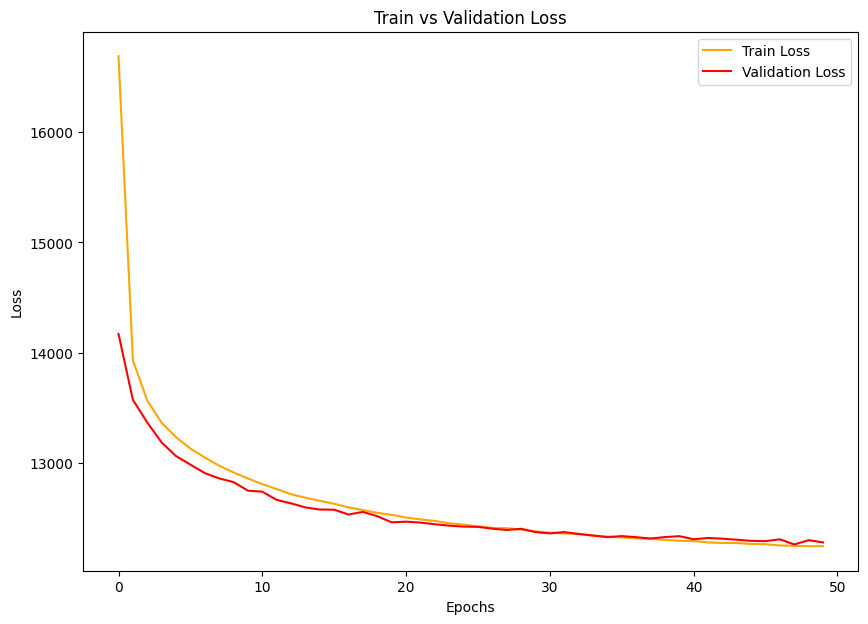

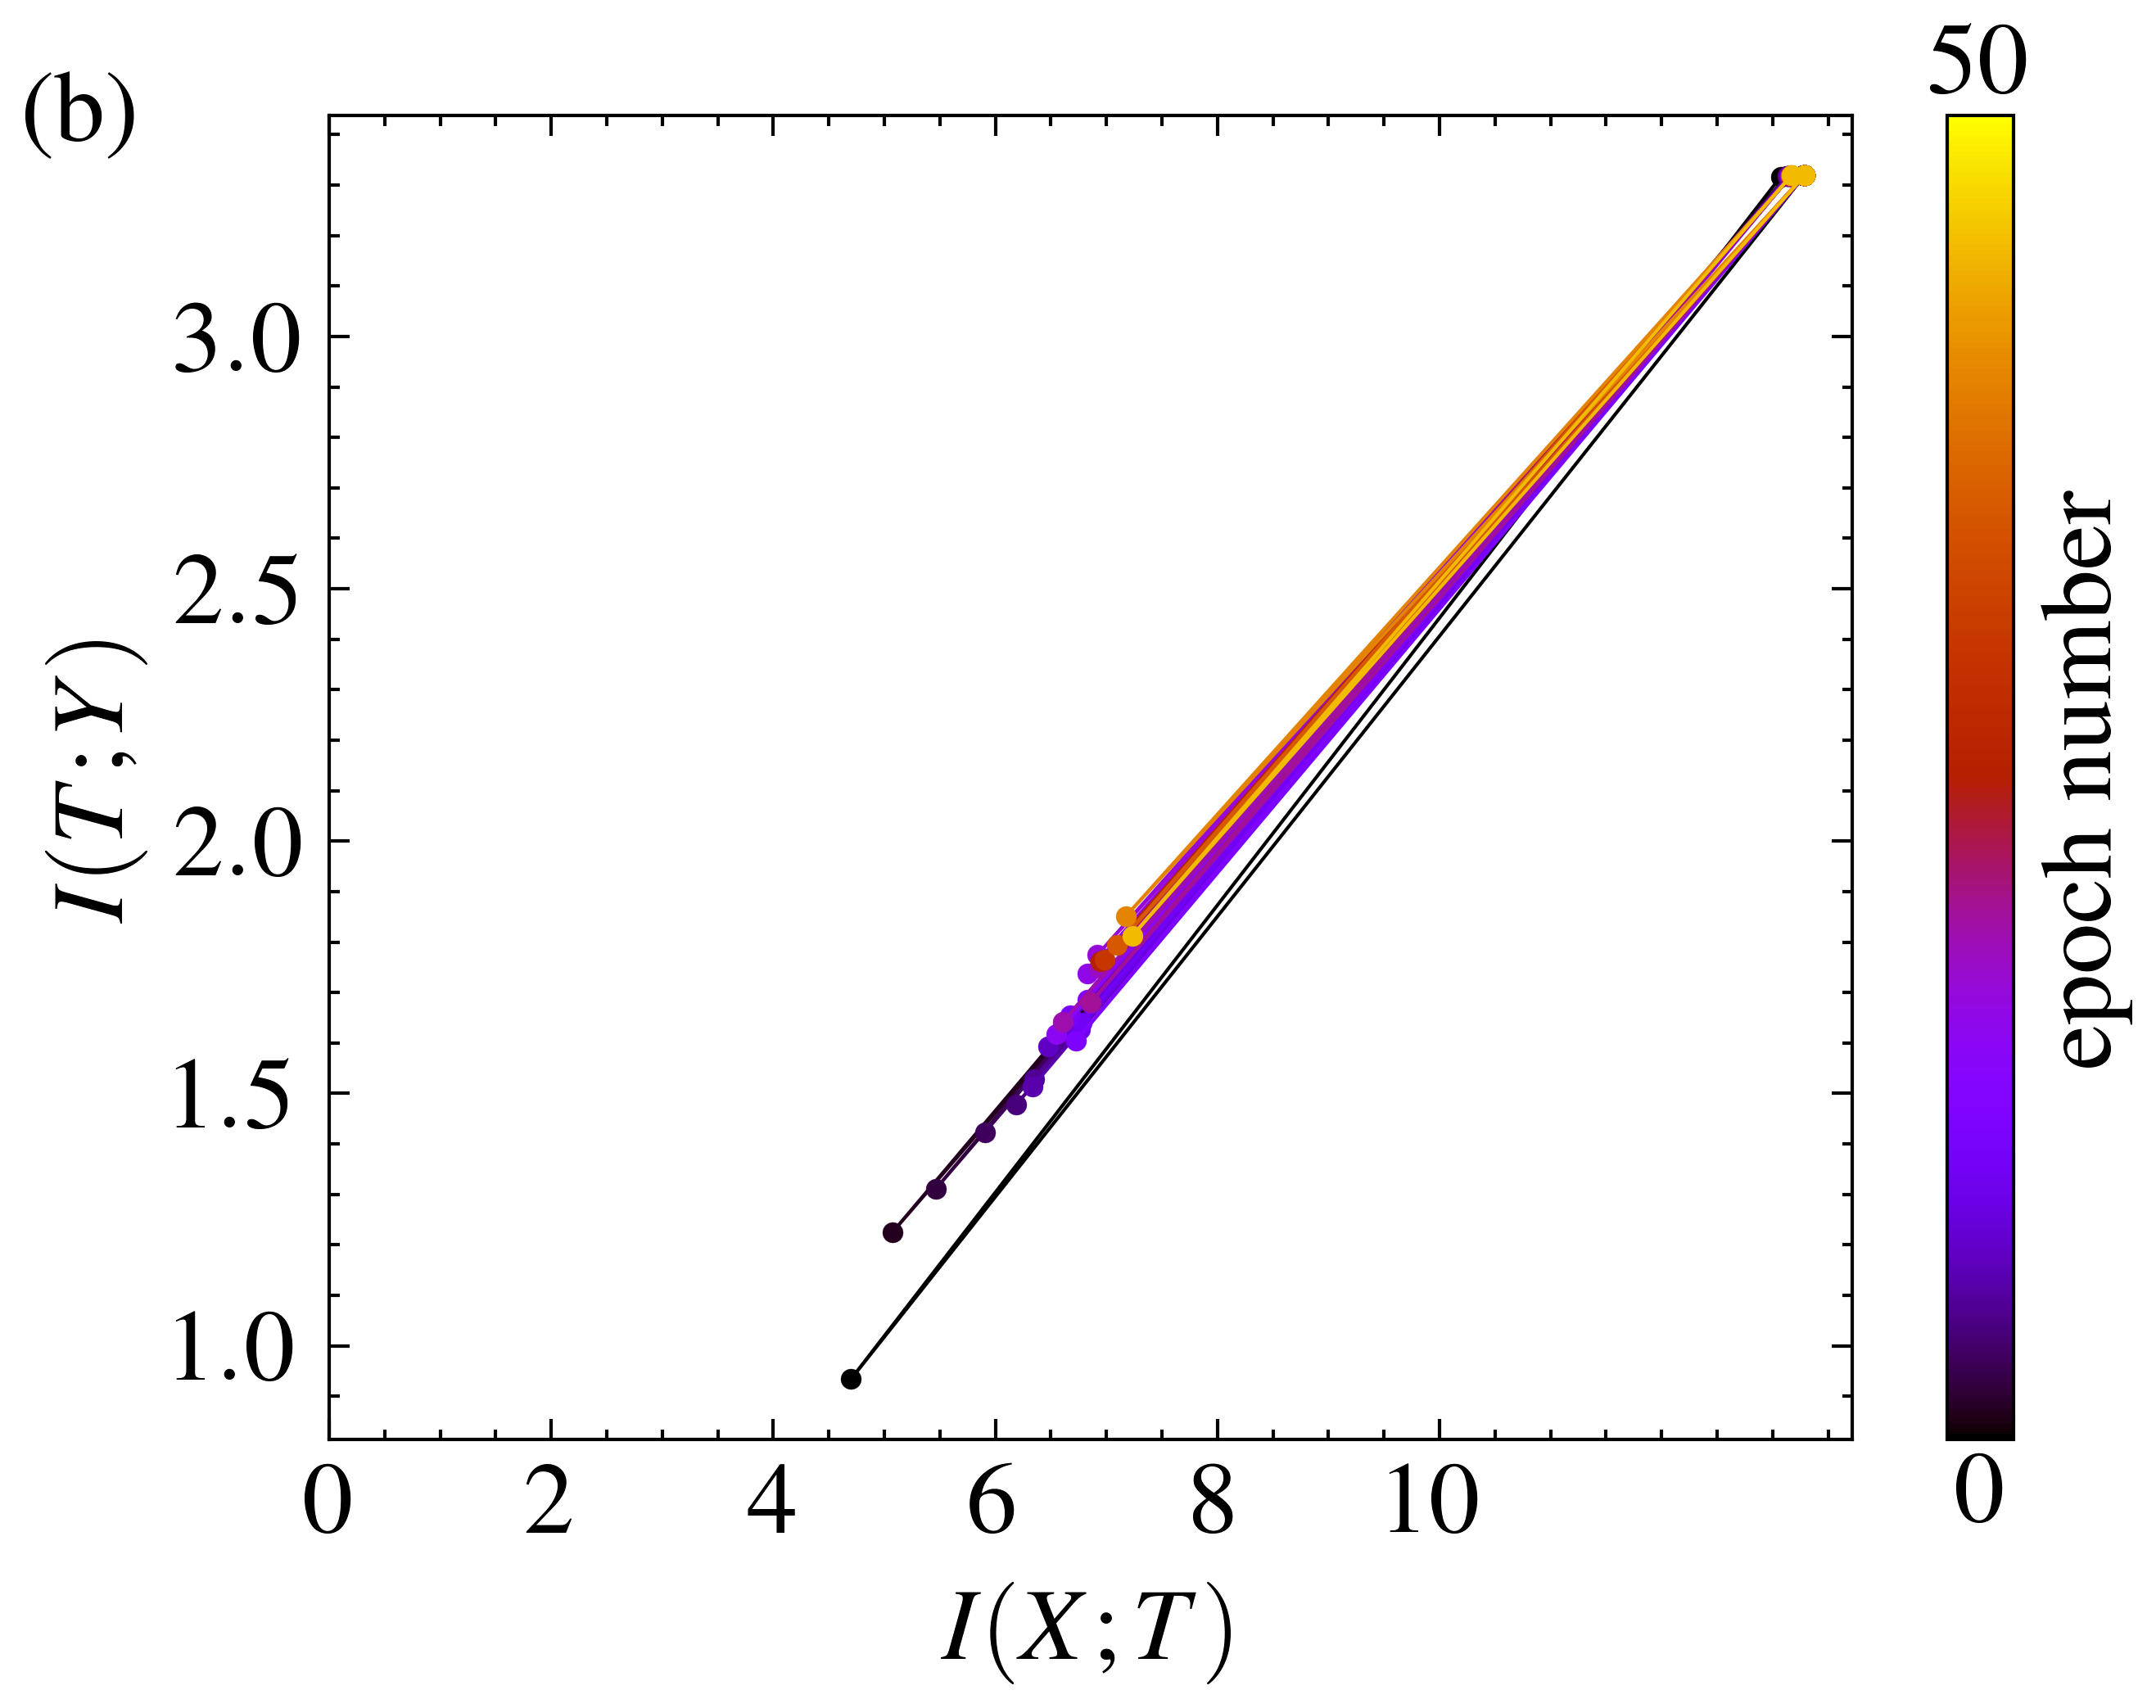

In [1]:
import torchvision
import kde
import simplebinmi
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
import scienceplots
import math
# train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')
accuracy_R = []
class VAE(nn.Module):
    def __init__(self, num_classes=10):
        super(VAE, self).__init__()

        # VAE部分
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2_mu = nn.Linear(512, 10)
        self.fc2_sig = nn.Linear(512, 10)
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 784)

        # 分类器部分
        self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10

    def encode(self, x, activations):
        x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
        a1 = F.relu(self.fc1(x))
        activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
        activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
        return a_mu, a_logvar

    def decode(self, z, activations):
        a3 = F.relu(self.fc3(z))
        activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
        a4 = torch.sigmoid(self.fc4(a3))
        activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
        return a4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        activations = []  # 初始化激活值存储列表
        mu, logvar = self.encode(x.view(-1, 784), activations)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, activations)

        # 分类任务
        class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类

        return recon_x, mu, logvar, class_output, activations



# 数据加载
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)


# 模型初始化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)  # 将模型加载到指定设备
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# 损失函数
# 定义 BETA 超参数
BETA = 1.5

def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
    # 重建损失（Binary Cross-Entropy）
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # 信息瓶颈损失（KL 散度）
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)

    # 分类损失（Cross-Entropy）
    CE = 0
    if class_output is not None and labels is not None:
        CE = F.cross_entropy(class_output, labels)

    # 总损失
    total_loss = CE + BCE + BETA * KL
    return total_loss


# 训练阶段
num_epochs = 50
print_per = 100
# 初始化损失记录列表
train_losses = []
valid_losses = []
class MI_Plate():
    def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()

        self.n_epochs = num_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):

        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')

        # if train_on_gpu:
        #     model.cuda()

        for epoch in range(self.n_epochs):
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                # if train_on_gpu:
                #     data, target = data.cuda(), target.cuda()  # Move data to GPU
                images = images.reshape(-1, 28 * 28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_output, activations = model(images)
                loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)  # 平均训练损失
            train_losses.append(train_loss)


            model.eval()
            for data, _ in full_data_loader:
                # if train_on_gpu:
                #     data = data.cuda()  # Move data to GPU
                recon_x, mu, logvar, class_output, activations = model(data)
            # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:  # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):  # Then every 100th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)


            valid_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.reshape(-1, 28 * 28).to(device)
                    labels = labels.to(device)

                    # 通过VAE模型进行前向传播
                    recon_batch, mu, logvar, class_output, activations = model(images)
                    # 使用mu通过分类器进行预测
                    class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
                    predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签

                    # 计算分类准确率
                    total += labels.size(0)
                    correct += (predicted_labels == labels).sum().item()
                    # 计算重建损失
                    loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                    valid_loss += loss.item()

            # 平均验证损失
            valid_loss /= len(test_loader)
            # 计算分类准确率
            accuracy = 100 * correct / total

            valid_losses.append(valid_loss)  # 记录验证损失
            accuracy_R.append(accuracy) 
            np.save(r'/root/lossR.npy', np.array(valid_losses))
            np.save(r'/root/accuracy_R.npy', np.array(accuracy_R))   
            print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def compute_MI(self, noise_variance=1e-1):

        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance

        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)

        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0 / np.log(2)

        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
        ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['ReLU'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['ReLU']:  # Skip this epoch if its already been processed
                continue  # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []

            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    # h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper = 0.0
                for i in range(10):
                    # 修正 saved_labelixs 为适配 activity 的布尔索引
                    batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
                    saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引

                    # 计算条件熵
                    hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower = 0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
                cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
                cepochdata['H_M_upper'].append(nats2bits * h_upper)

                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)

                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
                cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
                    cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
                    cepochdata['H_M_lower'].append(nats2bits * h_lower)
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED:  # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append(nats2bits * binxm)
                    cepochdata['MI_YM_bin'].append(nats2bits * binym)
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr))

            measures['ReLU'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)


            # epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)

        # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_vibR.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_vibR.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)


Plate = MI_Plate()  # Create class object
Plate.save_activations()  # save activations if they weren't saved already
Plate.compute_MI()  # compute and save MIs if they weren't saved before


def save_loss_plot(train_loss, valid_loss):
    # 绘制损失曲线
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='Train Loss')
    plt.plot(valid_loss, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    
    plt.savefig('loss_vibR1.eps')  # 保存为图片文件
    plt.show()

# 调用函数绘制损失图
save_loss_plot(train_losses, valid_losses)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})


def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i]
        ITY = ITY_array[i]

        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10])
    # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/vibR.eps', dpi=800)
    plt.show()


IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibR.npy', allow_pickle=True)

ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibR.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)

Saving activations/epoch00000000
Epoch [0/50], Validation Loss: 14130.4478, Accuracy: 74.99%
Saving activations/epoch00000001
Epoch [1/50], Validation Loss: 13498.3119, Accuracy: 82.08%
Saving activations/epoch00000002
Epoch [2/50], Validation Loss: 13270.6587, Accuracy: 83.97%
Saving activations/epoch00000003
Epoch [3/50], Validation Loss: 13190.3775, Accuracy: 84.47%
Saving activations/epoch00000004
Epoch [4/50], Validation Loss: 13067.3037, Accuracy: 85.08%
Saving activations/epoch00000005
Epoch [5/50], Validation Loss: 13028.0440, Accuracy: 85.13%
Saving activations/epoch00000006
Epoch [6/50], Validation Loss: 12955.9307, Accuracy: 85.90%
Saving activations/epoch00000007
Epoch [7/50], Validation Loss: 12885.8882, Accuracy: 86.03%
Saving activations/epoch00000008
Epoch [8/50], Validation Loss: 12868.1969, Accuracy: 86.25%
Saving activations/epoch00000009
Epoch [9/50], Validation Loss: 12814.4677, Accuracy: 86.04%
Saving activations/epoch00000010
Epoch [10/50], Validation Loss: 12764

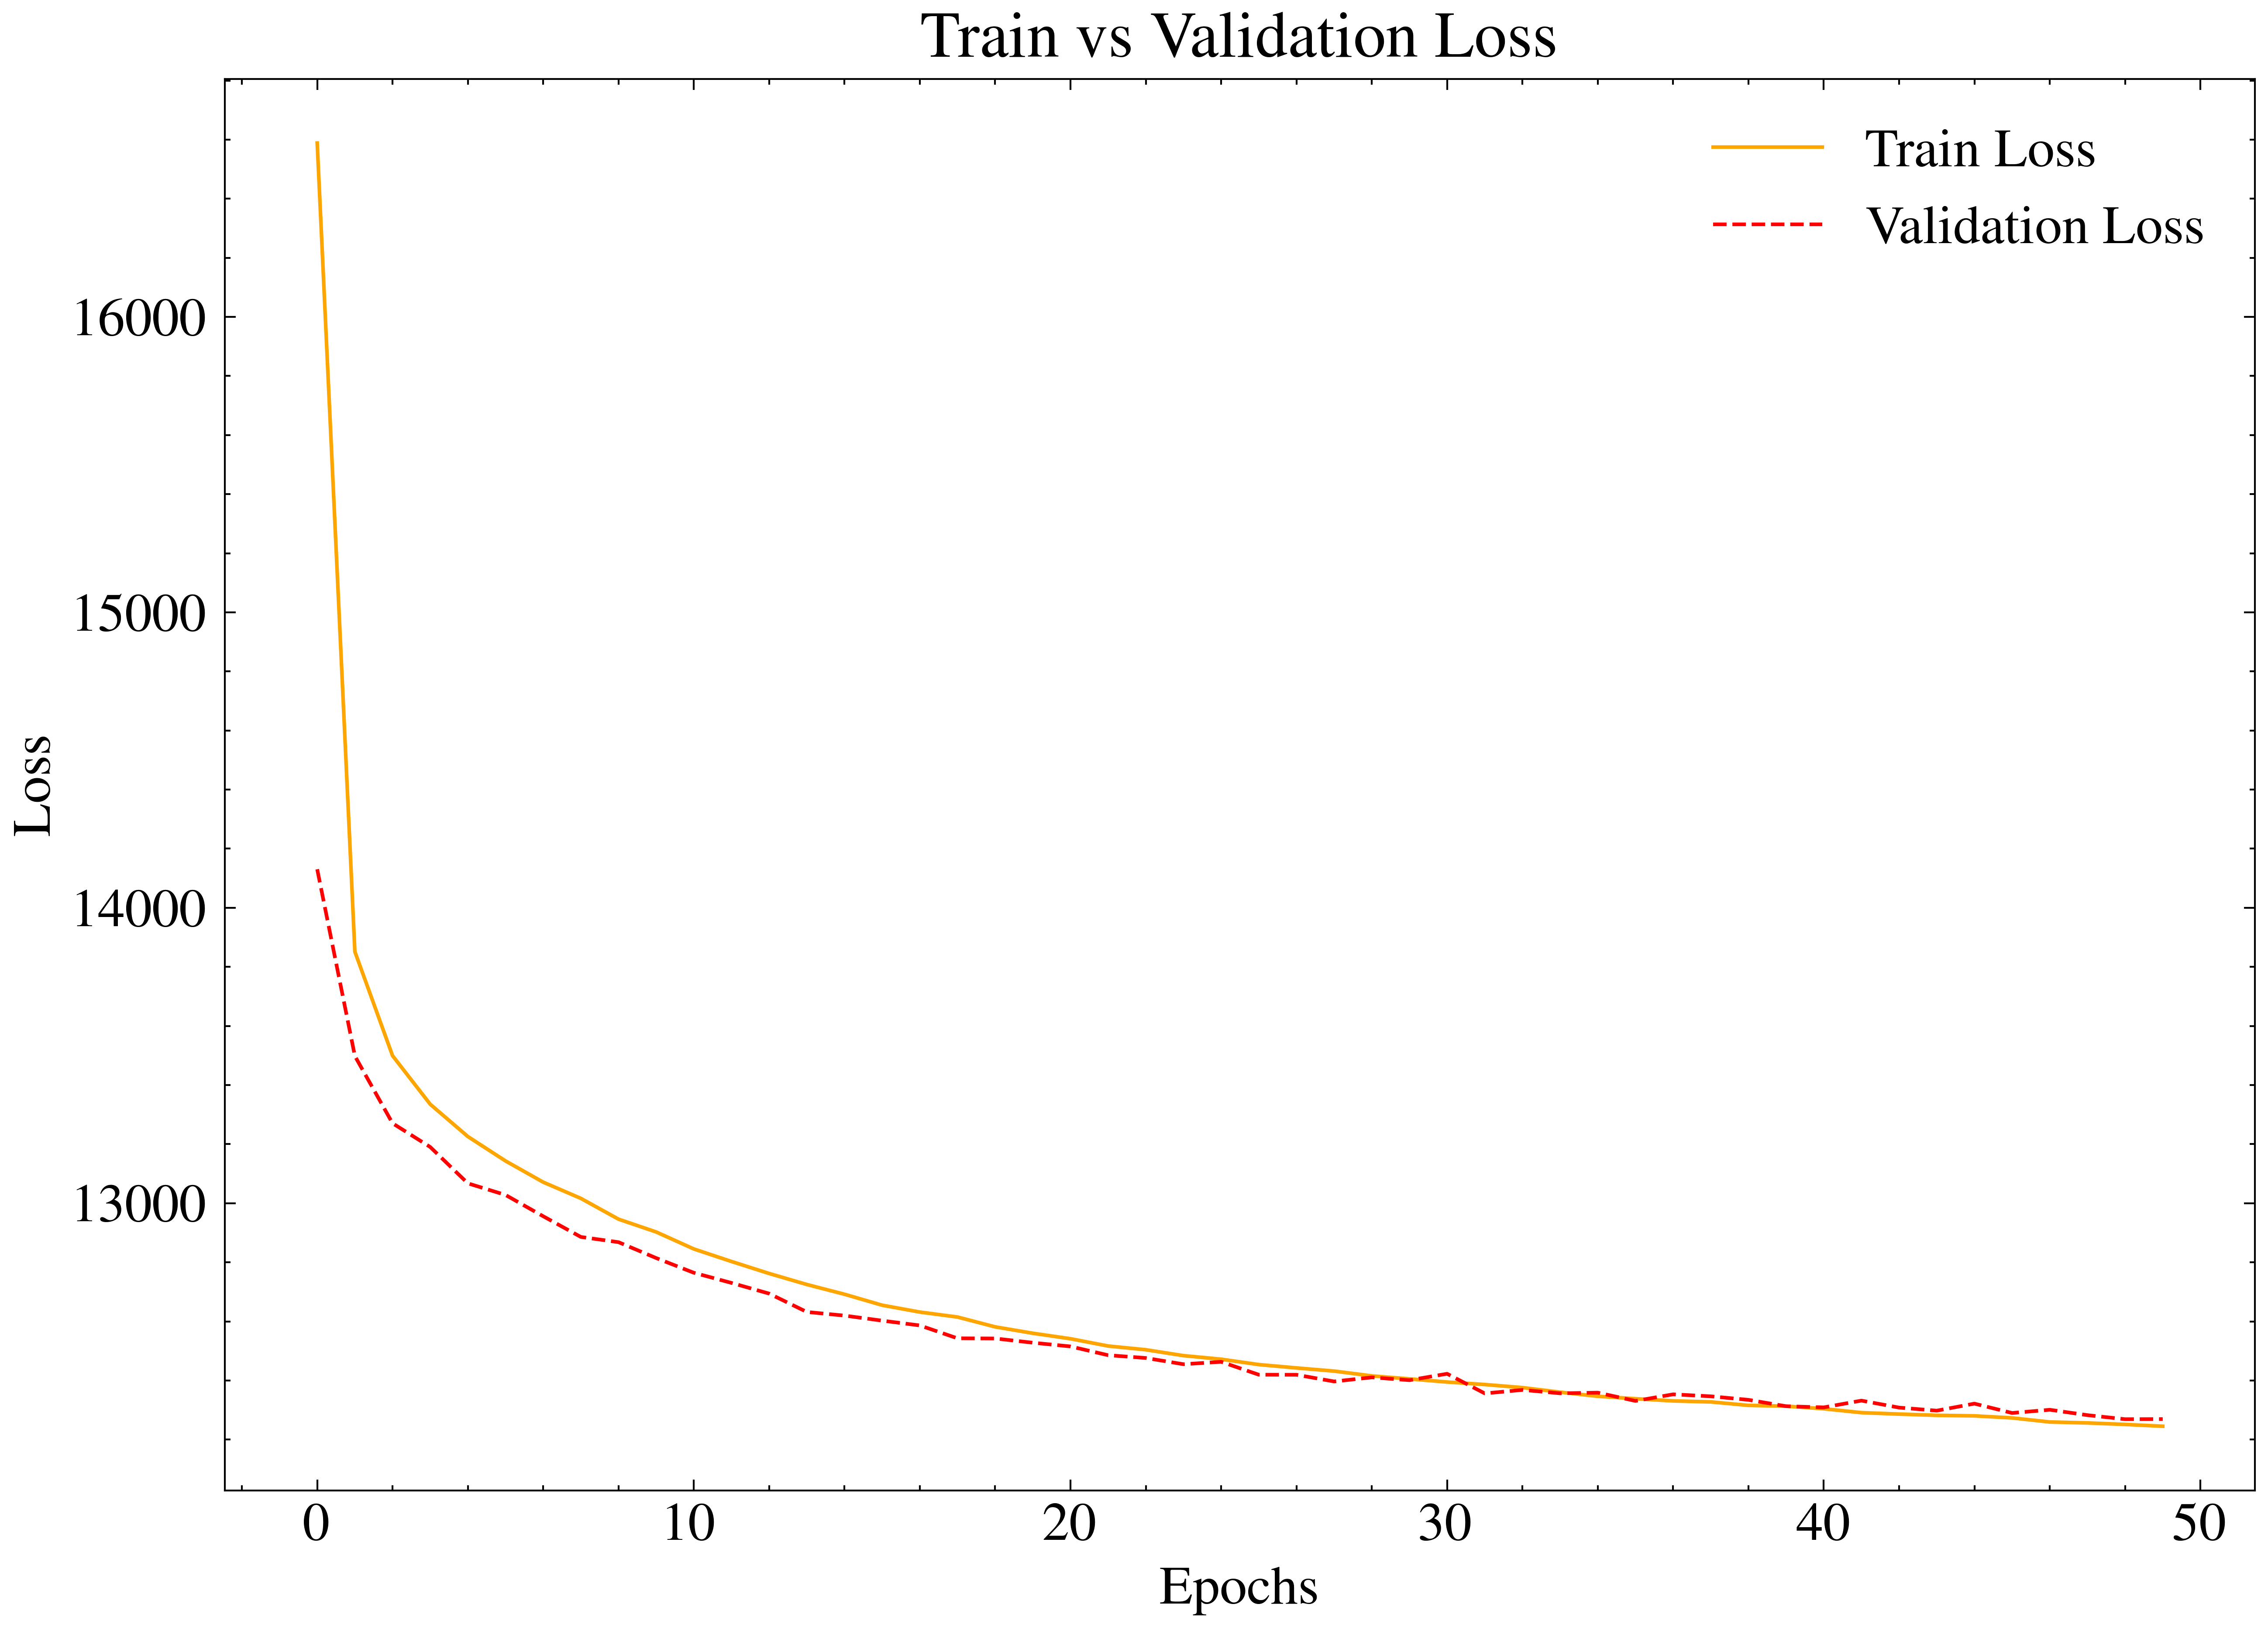

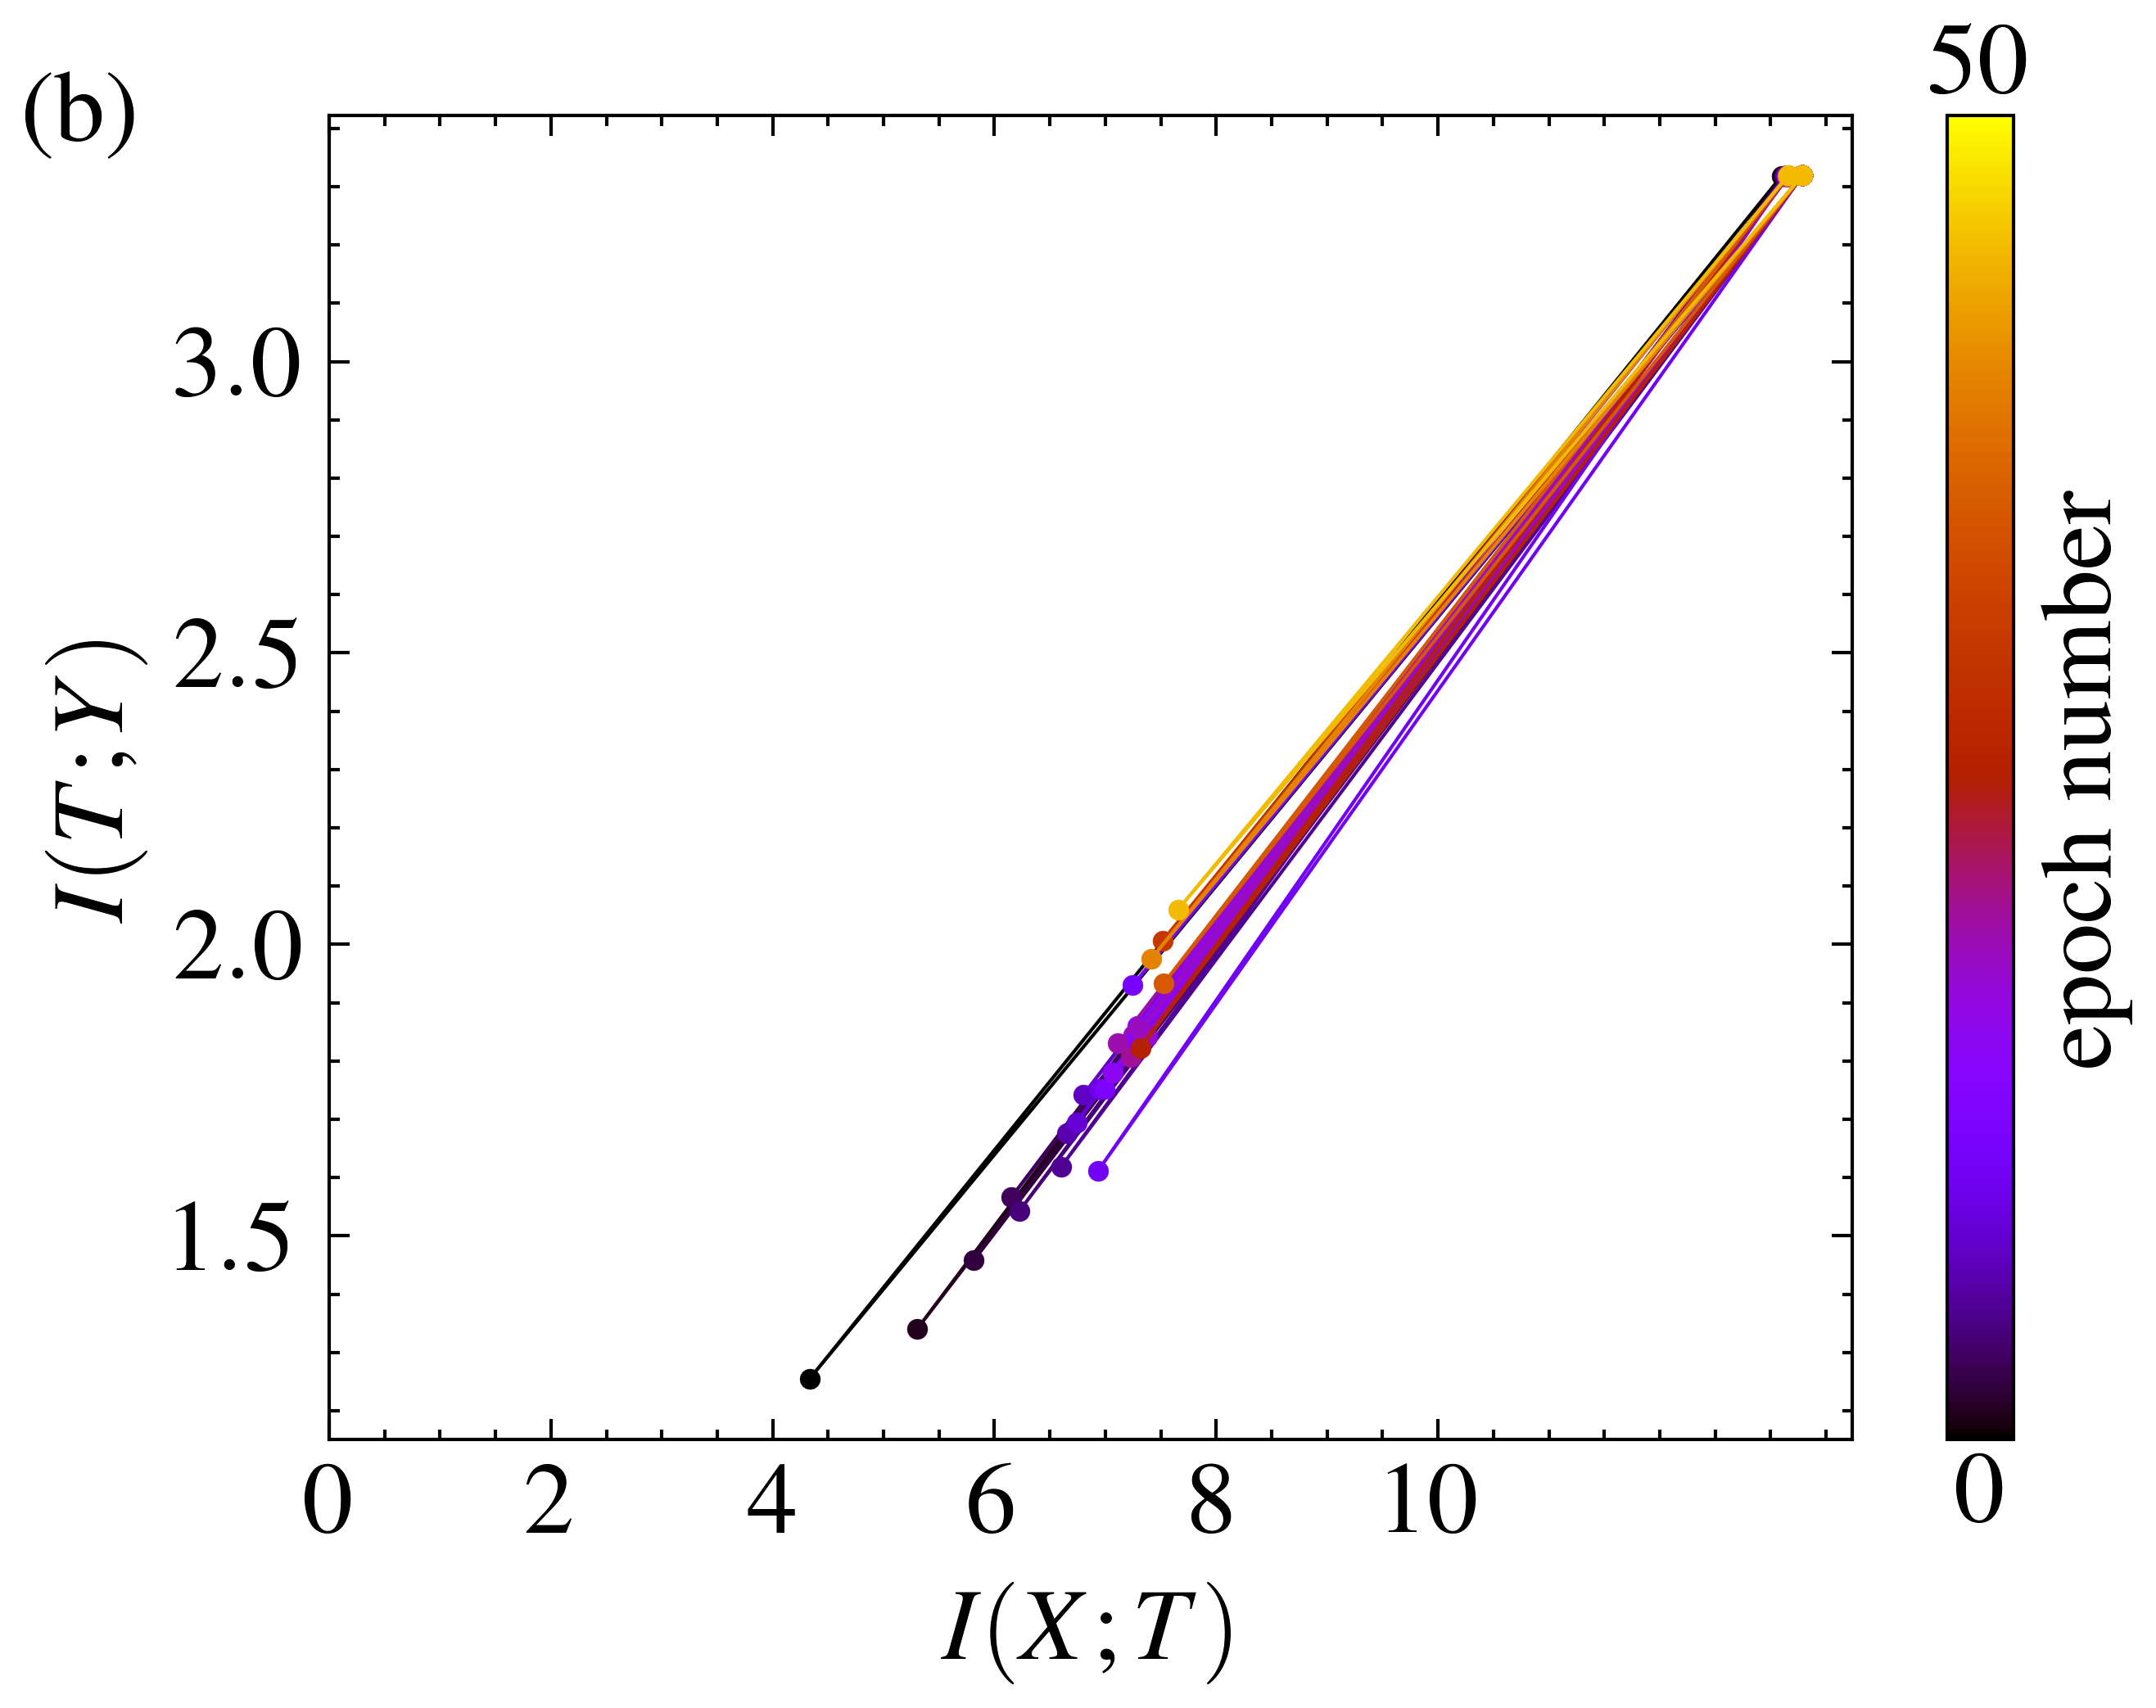

In [2]:
import torchvision
import kde
import simplebinmi
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
import scienceplots
import math
# train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')
accuracy_M = []
class VAE(nn.Module):
    def __init__(self, num_classes=10):
        super(VAE, self).__init__()

        # VAE部分
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2_mu = nn.Linear(512, 10)
        self.fc2_sig = nn.Linear(512, 10)
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 784)

        # 分类器部分
        self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10

    def encode(self, x, activations):
        x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
        a1 = F.mish(self.fc1(x))
        activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
        activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
        return a_mu, a_logvar

    def decode(self, z, activations):
        a3 = F.mish(self.fc3(z))
        activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
        a4 = torch.sigmoid(self.fc4(a3))
        activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
        return a4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        activations = []  # 初始化激活值存储列表
        mu, logvar = self.encode(x.view(-1, 784), activations)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, activations)

        # 分类任务
        class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类

        return recon_x, mu, logvar, class_output, activations



# 数据加载
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)


# 模型初始化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)  # 将模型加载到指定设备
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# 损失函数
# 定义 BETA 超参数
BETA = 1.5

def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
    # 重建损失（Binary Cross-Entropy）
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # 信息瓶颈损失（KL 散度）
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)

    # 分类损失（Cross-Entropy）
    CE = 0
    if class_output is not None and labels is not None:
        CE = F.cross_entropy(class_output, labels)

    # 总损失
    total_loss = CE + BCE + BETA * KL
    return total_loss


# 训练阶段
num_epochs = 50
print_per = 100
# 初始化损失记录列表
train_losses = []
valid_losses = []
class MI_Plate():
    def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()

        self.n_epochs = num_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):

        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')

        # if train_on_gpu:
        #     model.cuda()

        for epoch in range(self.n_epochs):
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                # if train_on_gpu:
                #     data, target = data.cuda(), target.cuda()  # Move data to GPU
                images = images.reshape(-1, 28 * 28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_output, activations = model(images)
                loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)  # 平均训练损失
            train_losses.append(train_loss)


            model.eval()
            for data, _ in full_data_loader:
                # if train_on_gpu:
                #     data = data.cuda()  # Move data to GPU
                recon_x, mu, logvar, class_output, activations = model(data)
            # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:  # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):  # Then every 100th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)


            valid_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.reshape(-1, 28 * 28).to(device)
                    labels = labels.to(device)

                    # 通过VAE模型进行前向传播
                    recon_batch, mu, logvar, class_output, activations = model(images)
                    # 使用mu通过分类器进行预测
                    class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
                    predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签

                    # 计算分类准确率
                    total += labels.size(0)
                    correct += (predicted_labels == labels).sum().item()
                    # 计算重建损失
                    loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                    valid_loss += loss.item()

            # 平均验证损失
            valid_loss /= len(test_loader)
            # 计算分类准确率
            accuracy = 100 * correct / total

            valid_losses.append(valid_loss)  # 记录验证损失
            accuracy_M.append(accuracy) 
           
            np.save('D:/深度学习与信息论/accuracy_M.npy', np.array(accuracy_M)) 
            print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def compute_MI(self, noise_variance=1e-1):

        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance

        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)

        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0 / np.log(2)

        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
        ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['Mish'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['Mish']:  # Skip this epoch if its already been processed
                continue  # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []

            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    # h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper = 0.0
                for i in range(10):
                    # 修正 saved_labelixs 为适配 activity 的布尔索引
                    batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
                    saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引

                    # 计算条件熵
                    hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower = 0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
                cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
                cepochdata['H_M_upper'].append(nats2bits * h_upper)

                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)

                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
                cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
                    cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
                    cepochdata['H_M_lower'].append(nats2bits * h_lower)
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED:  # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append(nats2bits * binxm)
                    cepochdata['MI_YM_bin'].append(nats2bits * binym)
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr))

            measures['Mish'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)


            # epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)

        # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_vibM.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_vibM.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)


Plate = MI_Plate()  # Create class object
Plate.save_activations()  # save activations if they weren't saved already
Plate.compute_MI()  # compute and save MIs if they weren't saved before


def save_loss_plot(train_loss, valid_loss):
    # 绘制损失曲线
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='Train Loss')
    plt.plot(valid_loss, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    
    plt.savefig('loss_vibM.eps')  # 保存为图片文件
    plt.show()

# 调用函数绘制损失图
save_loss_plot(train_losses, valid_losses)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})


def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i]
        ITY = ITY_array[i]

        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10])
    # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/vibM.eps', dpi=800)
    plt.show()


IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibM.npy', allow_pickle=True)

ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibM.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)

Saving activations/epoch00000000
Epoch [0/50], Validation Loss: 14898.9264, Accuracy: 71.58%
Saving activations/epoch00000001
Epoch [1/50], Validation Loss: 14029.3504, Accuracy: 79.32%
Saving activations/epoch00000002
Epoch [2/50], Validation Loss: 13697.9472, Accuracy: 80.89%
Saving activations/epoch00000003
Epoch [3/50], Validation Loss: 13512.1060, Accuracy: 83.15%
Saving activations/epoch00000004
Epoch [4/50], Validation Loss: 13332.2045, Accuracy: 83.82%
Saving activations/epoch00000005
Epoch [5/50], Validation Loss: 13229.3784, Accuracy: 84.30%
Saving activations/epoch00000006
Epoch [6/50], Validation Loss: 13183.1419, Accuracy: 84.59%
Saving activations/epoch00000007
Epoch [7/50], Validation Loss: 13105.6273, Accuracy: 85.04%
Saving activations/epoch00000008
Epoch [8/50], Validation Loss: 13050.3164, Accuracy: 85.56%
Saving activations/epoch00000009
Epoch [9/50], Validation Loss: 13047.8182, Accuracy: 85.08%
Saving activations/epoch00000010
Epoch [10/50], Validation Loss: 12978

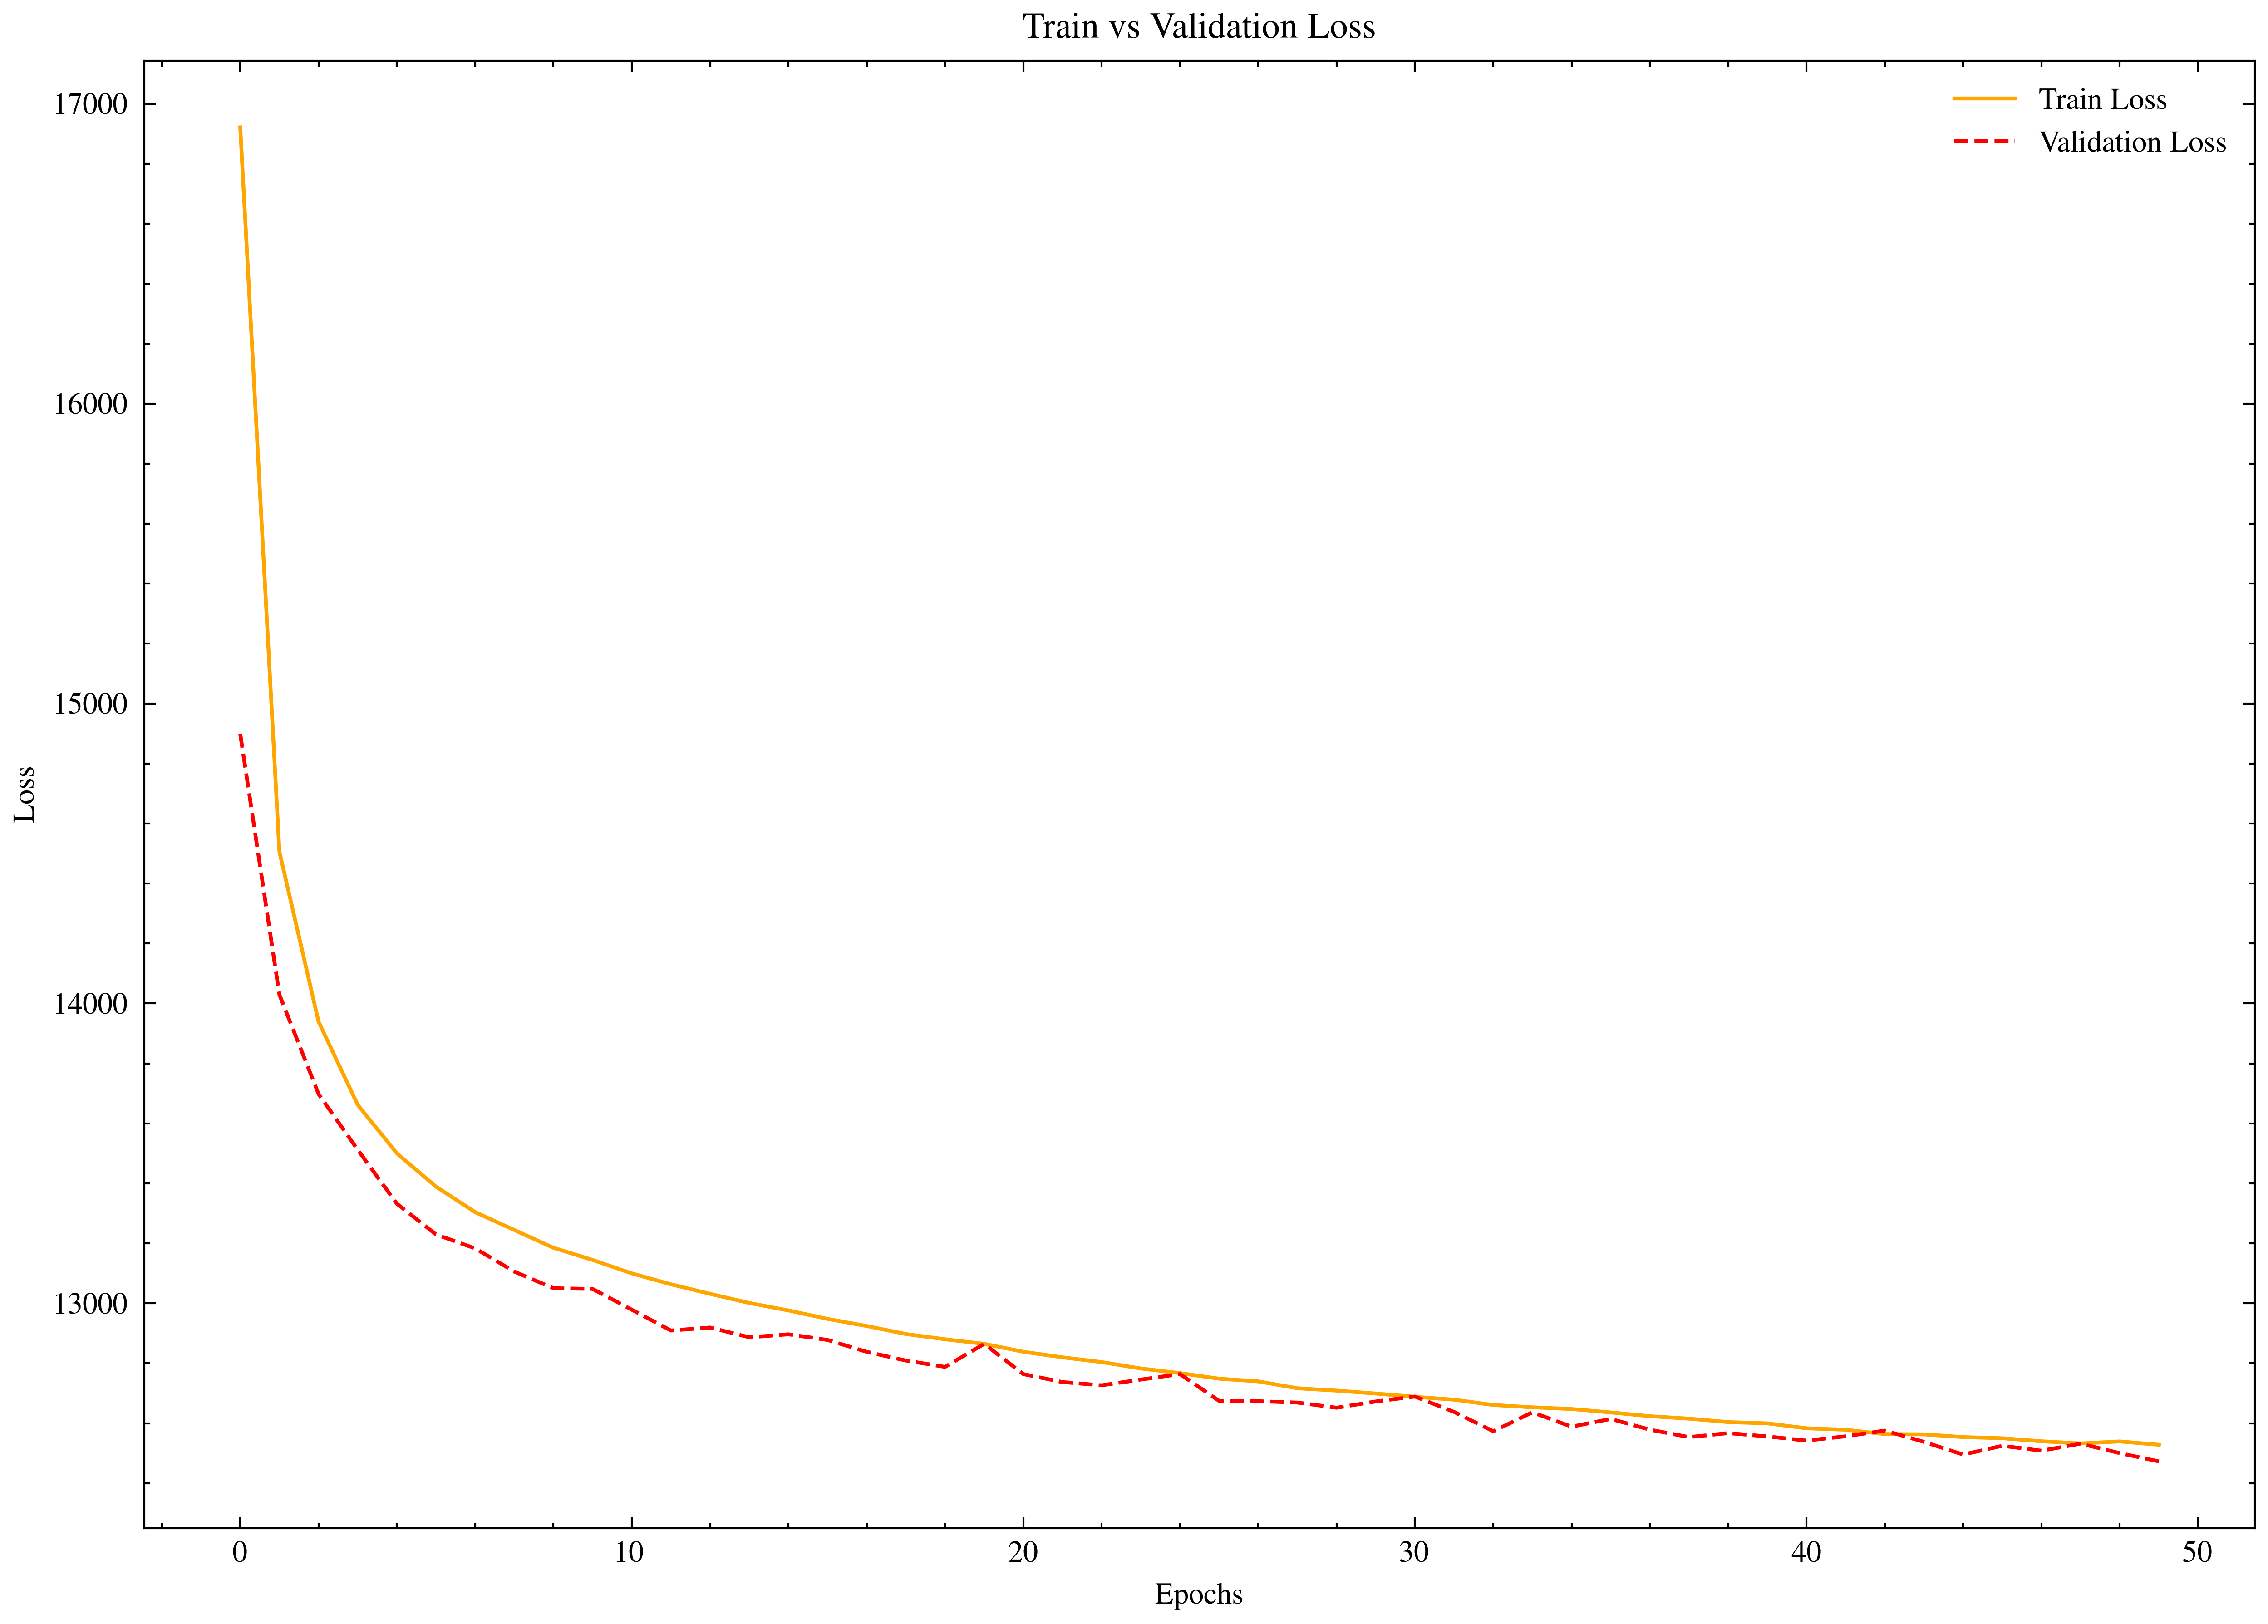

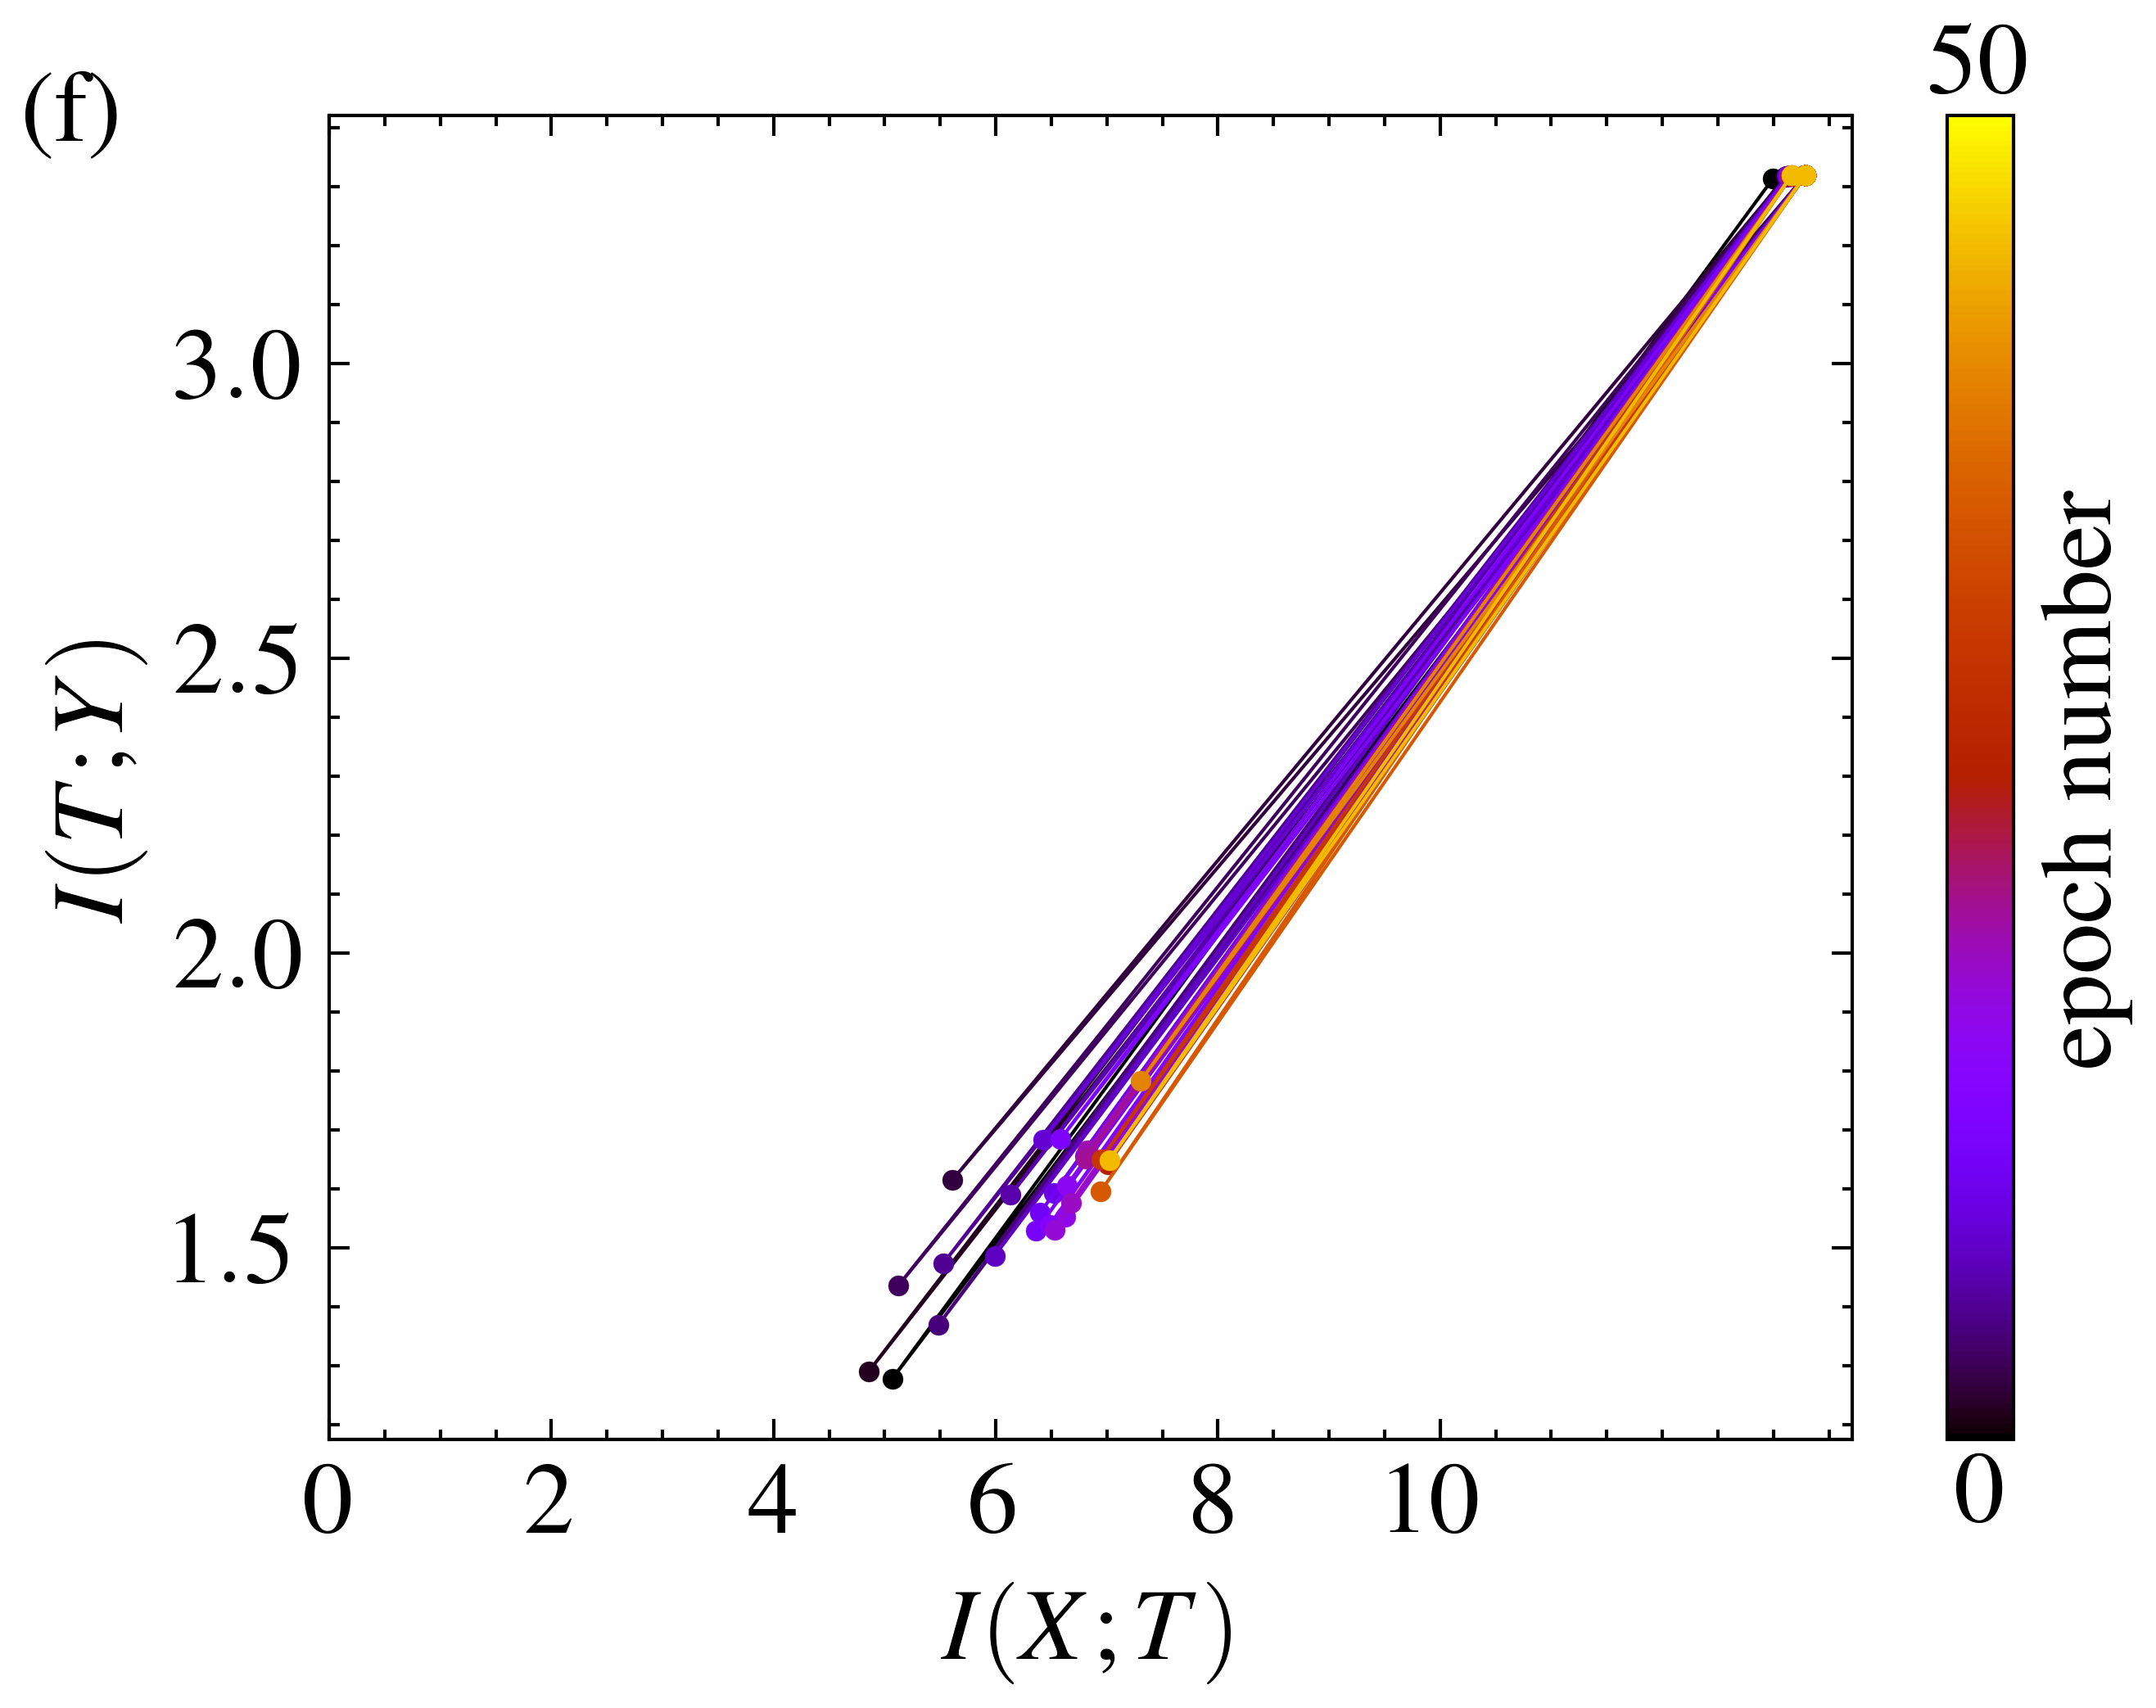

In [13]:
import torchvision
import kde
import simplebinmi
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
import scienceplots
import math
# train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')
accuracy_E = []
class VAE(nn.Module):
    def __init__(self, num_classes=10):
        super(VAE, self).__init__()

        # VAE部分
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2_mu = nn.Linear(512, 10)
        self.fc2_sig = nn.Linear(512, 10)
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 784)

        # 分类器部分
        self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10

    def encode(self, x, activations):
        x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
        a1 = F.elu(self.fc1(x))
        activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
        activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
        return a_mu, a_logvar

    def decode(self, z, activations):
        a3 = F.elu(self.fc3(z))
        activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
        a4 = torch.sigmoid(self.fc4(a3))
        activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
        return a4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        activations = []  # 初始化激活值存储列表
        mu, logvar = self.encode(x.view(-1, 784), activations)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, activations)

        # 分类任务
        class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类

        return recon_x, mu, logvar, class_output, activations



# 数据加载
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)


# 模型初始化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)  # 将模型加载到指定设备
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# 损失函数
# 定义 BETA 超参数
BETA = 1.5

def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
    # 重建损失（Binary Cross-Entropy）
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # 信息瓶颈损失（KL 散度）
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)

    # 分类损失（Cross-Entropy）
    CE = 0
    if class_output is not None and labels is not None:
        CE = F.cross_entropy(class_output, labels)

    # 总损失
    total_loss = CE + BCE + BETA * KL
    return total_loss


# 训练阶段
num_epochs = 50
print_per = 100
# 初始化损失记录列表
train_losses = []
valid_losses = []
class MI_Plate():
    def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()

        self.n_epochs = num_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):

        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')

        # if train_on_gpu:
        #     model.cuda()

        for epoch in range(self.n_epochs):
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                # if train_on_gpu:
                #     data, target = data.cuda(), target.cuda()  # Move data to GPU
                images = images.reshape(-1, 28 * 28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_output, activations = model(images)
                loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)  # 平均训练损失
            train_losses.append(train_loss)


            model.eval()
            for data, _ in full_data_loader:
                # if train_on_gpu:
                #     data = data.cuda()  # Move data to GPU
                recon_x, mu, logvar, class_output, activations = model(data)
            # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:  # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):  # Then every 100th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)


            valid_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.reshape(-1, 28 * 28).to(device)
                    labels = labels.to(device)

                    # 通过VAE模型进行前向传播
                    recon_batch, mu, logvar, class_output, activations = model(images)
                    # 使用mu通过分类器进行预测
                    class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
                    predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签

                    # 计算分类准确率
                    total += labels.size(0)
                    correct += (predicted_labels == labels).sum().item()
                    # 计算重建损失
                    loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                    valid_loss += loss.item()

            # 平均验证损失
            valid_loss /= len(test_loader)
            # 计算分类准确率
            accuracy = 100 * correct / total

            valid_losses.append(valid_loss)  # 记录验证损失
            accuracy_E.append(accuracy) 
           
            np.save('D:/深度学习与信息论/accuracy_E.npy', np.array(accuracy_E)) 

            print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def compute_MI(self, noise_variance=1e-1):

        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance

        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)

        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0 / np.log(2)

        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
        ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['ELU'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['ELU']:  # Skip this epoch if its already been processed
                continue  # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []

            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    # h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper = 0.0
                for i in range(10):
                    # 修正 saved_labelixs 为适配 activity 的布尔索引
                    batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
                    saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引

                    # 计算条件熵
                    hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower = 0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
                cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
                cepochdata['H_M_upper'].append(nats2bits * h_upper)

                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)

                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
                cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
                    cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
                    cepochdata['H_M_lower'].append(nats2bits * h_lower)
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED:  # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append(nats2bits * binxm)
                    cepochdata['MI_YM_bin'].append(nats2bits * binym)
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr))

            measures['ELU'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)


            # epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)

        # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_vibE.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_vibE.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)


Plate = MI_Plate()  # Create class object
Plate.save_activations()  # save activations if they weren't saved already
Plate.compute_MI()  # compute and save MIs if they weren't saved before


def save_loss_plot(train_loss, valid_loss):
    # 绘制损失曲线
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='Train Loss')
    plt.plot(valid_loss, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    
    plt.savefig('loss_vibM.eps')  # 保存为图片文件
    plt.show()

# 调用函数绘制损失图
save_loss_plot(train_losses, valid_losses)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})


def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i]
        ITY = ITY_array[i]

        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10])
    # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(f)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/vibE.eps', dpi=800)
    plt.show()


IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibE.npy', allow_pickle=True)

ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibE.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)                                                                                                                  

In [4]:
# import torchvision
# import kde
# import simplebinmi
# import os
# from collections import defaultdict, OrderedDict#为了自动建目录
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# import pickle
# from torchvision import datasets
# import torchvision.transforms as transforms
# import matplotlib as mpl
# import scienceplots
# import math
# # train_on_gpu = torch.cuda.is_available()
# ##判断是否有GPU
# # if not train_on_gpu:
# #     print('CUDA is not available.  Training on CPU ...')
# # else:
# #     print('CUDA is available!  Training on GPU ...')
# accuracy_M2 = []
# 
# class CustomActivation(nn.Module):
#     def __init__(self):
#         super(CustomActivation, self).__init__()
#         self.sigma = nn.Parameter(torch.tensor(1.0))  # 可训练的 sigma 参数
# 
#     def forward(self, input):
#         return input * torch.tanh(torch.log1p(torch.exp(input / self.sigma)))
# 
# class VAE(nn.Module):
#     def __init__(self, num_classes=10):
#         super(VAE, self).__init__()
# 
#         # VAE部分
#         self.fc1 = nn.Linear(28 * 28, 512)
#         self.fc2_mu = nn.Linear(512, 10)
#         self.fc2_sig = nn.Linear(512, 10)
#         self.fc3 = nn.Linear(10, 512)
#         self.fc4 = nn.Linear(512, 784)
# 
#         # 分类器部分
#         self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10
#         # 激活函数
#         self.custom_activation = CustomActivation()
# 
#     def encode(self, x, activations):
#         x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
#         a1 = self.custom_activation(self.fc1(x))
#         activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
#         a_mu = self.fc2_mu(a1)
#         a_logvar = self.fc2_sig(a1)
#         activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
#         activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
#         return a_mu, a_logvar
# 
#     def decode(self, z, activations):
#         a3 = self.custom_activation(self.fc3(z))
#         activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
#         a4 = torch.sigmoid(self.fc4(a3))
#         activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
#         return a4
# 
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return eps * std + mu
# 
#     def forward(self, x):
#         activations = []  # 初始化激活值存储列表
#         mu, logvar = self.encode(x.view(-1, 784), activations)
#         z = self.reparameterize(mu, logvar)
#         recon_x = self.decode(z, activations)
# 
#         # 分类任务
#         class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类
# 
#         return recon_x, mu, logvar, class_output, activations
# 
# 
# 
# # 数据加载
# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
# 
# full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)
# 
# 
# # 模型初始化
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = VAE().to(device)  # 将模型加载到指定设备
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# 
# 
# 
# # 损失函数
# # 定义 BETA 超参数
# BETA = 1.5
# 
# def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
#     # 重建损失（Binary Cross-Entropy）
#     BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
# 
#     # 信息瓶颈损失（KL 散度）
#     KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)
# 
#     # 分类损失（Cross-Entropy）
#     CE = 0
#     if class_output is not None and labels is not None:
#         CE = F.cross_entropy(class_output, labels)
# 
#     # 总损失
#     total_loss = CE + BCE + BETA * KL
#     return total_loss
# 
# 
# # 训练阶段
# num_epochs = 50
# print_per = 100
# # 初始化损失记录列表
# train_losses = []
# valid_losses = []
# class MI_Plate():
#     def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
#         super(MI_Plate, self).__init__()
# 
#         self.n_epochs = num_epochs
#         self.DO_LOWER = DO_LOWER
#         self.DO_BINNED = DO_BINNED
#         self.PLOT_LAYERS = PLOT_LAYERS
# 
#     # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
#     def save_activations(self):
# 
#         if not os.path.exists('activations'):
#             print("Making directory", 'activations')
#             os.mkdir('activations')
# 
#         # if train_on_gpu:
#         #     model.cuda()
# 
#         for epoch in range(self.n_epochs):
#             model.train()
#             train_loss = 0
#             for images, labels in train_loader:
#                 # if train_on_gpu:
#                 #     data, target = data.cuda(), target.cuda()  # Move data to GPU
#                 images = images.reshape(-1, 28 * 28).to(device)
#                 labels = labels.to(device)
#                 optimizer.zero_grad()
#                 recon_batch, mu, logvar, class_output, activations = model(images)
#                 loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
#                 loss.backward()
#                 optimizer.step()
#                 train_loss += loss.item()
# 
#             train_loss /= len(train_loader)  # 平均训练损失
#             train_losses.append(train_loss)
# 
# 
#             model.eval()
#             for data, _ in full_data_loader:
#                 # if train_on_gpu:
#                 #     data = data.cuda()  # Move data to GPU
#                 recon_x, mu, logvar, class_output, activations = model(data)
#             # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
#             if epoch < 20:  # Log for all first 20 epochs
#                 fname = 'activations' + "/epoch%08d" % epoch
#                 print("Saving", fname)
#                 with open(fname, 'wb') as f:
#                     pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
#             # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
#             elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
#                 fname = 'activations' + "/epoch%08d" % epoch
#                 print("Saving", fname)
#                 with open(fname, 'wb') as f:
#                     pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
#             elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
#                 fname = 'activations' + "/epoch%08d" % epoch
#                 print("Saving", fname)
#                 with open(fname, 'wb') as f:
#                     pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
#             elif (epoch % 100 == 0):  # Then every 100th
#                 fname = 'activations' + "/epoch%08d" % epoch
#                 print("Saving", fname)
#                 with open(fname, 'wb') as f:
#                     pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
# 
# 
#             valid_loss = 0
#             correct = 0
#             total = 0
# 
#             with torch.no_grad():
#                 for images, labels in test_loader:
#                     images = images.reshape(-1, 28 * 28).to(device)
#                     labels = labels.to(device)
# 
#                     # 通过VAE模型进行前向传播
#                     recon_batch, mu, logvar, class_output, activations = model(images)
#                     # 使用mu通过分类器进行预测
#                     class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
#                     predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签
# 
#                     # 计算分类准确率
#                     total += labels.size(0)
#                     correct += (predicted_labels == labels).sum().item()
#                     # 计算重建损失
#                     loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
#                     valid_loss += loss.item()
# 
#             # 平均验证损失
#             valid_loss /= len(test_loader)
#             # 计算分类准确率
#             accuracy = 100 * correct / total
# 
#             valid_losses.append(valid_loss)  # 记录验证损失
#             accuracy_M2.append(accuracy) 
#            
#             np.save('D:/深度学习与信息论/accuracy_M2.npy', np.array(accuracy_M2)) 
# 
#             print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")
# 
#     def compute_MI(self, noise_variance=1e-1):
# 
#         MAX_EPOCHS = self.n_epochs
#         self.noise_variance = noise_variance
# 
#         def entropy_func_upper(x):
#             return kde.entropy_estimator_kl(x, self.noise_variance)
# 
#         def entropy_func_lower(x):
#             return kde.entropy_estimator_bd(x, self.noise_variance)
# 
#         # nats to bits conversion factor
#         nats2bits = 1.0 / np.log(2)
# 
#         # Save indexes of tests data for each of the output classes
#         saved_labelixs = {}
#         for data, targets in full_data_loader:
#             trg = targets.numpy()
#         for i in range(10):
#             saved_labelixs[i] = trg == i
# 
#         labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)
# 
#         MI_XM_upper_array = []
#         MI_YM_upper_array = []
#         ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
#         measures = OrderedDict()
#         measures['Mish'] = {}
# 
#         cur_dir = 'activations'
#         if not os.path.exists(cur_dir):
#             print("Directory %s not found" % cur_dir)
# 
#         # Load files saved during each epoch, and compute MI measures of the activity in that epoch
#         print('*** Doing %s ***' % cur_dir)
#         for epochfile in sorted(os.listdir(cur_dir)):
#             if not epochfile.startswith('epoch'):
#                 continue
# 
#             fname = cur_dir + "/" + epochfile
#             with open(fname, 'rb') as f:
#                 d = pickle.load(f)
# 
#             epoch = d[1]
#             d = d[0]
#             if epoch in measures['Mish']:  # Skip this epoch if its already been processed
#                 continue  # this is a trick to allow us to rerun this cell multiple times)
# 
#             if epoch > MAX_EPOCHS:
#                 continue
# 
#             print("Doing", fname)
# 
#             num_layers = len(d)
# 
#             MI_XM_upper_epoch = []
#             MI_YM_upper_epoch = []
# 
#             if self.PLOT_LAYERS is None:
#                 PLOT_LAYERS = []
#                 for lndx in range(num_layers):
#                     PLOT_LAYERS.append(lndx)
# 
#             cepochdata = defaultdict(list)
#             for lndx in range(num_layers):
#                 activity = d[lndx]
# 
#                 # Compute marginal entropies
#                 h_upper = entropy_func_upper(activity)
#                 if self.DO_LOWER:
#                     # h_lower = entropy_func_lower([activity,])[0]
#                     h_lower = entropy_func_lower(activity)
# 
#                 # Layer activity given input. This is simply the entropy of the Gaussian noise
#                 hM_given_X = kde.kde_condentropy(activity, self.noise_variance)
# 
#                 # Compute conditional entropies of layer activity given output
#                 hM_given_Y_upper = 0.0
#                 for i in range(10):
#                     # 修正 saved_labelixs 为适配 activity 的布尔索引
#                     batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
#                     saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引
# 
#                     # 计算条件熵
#                     hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
#                     hM_given_Y_upper += labelprobs[i] * hcond_upper
# 
#                 if self.DO_LOWER:
#                     hM_given_Y_lower = 0.
#                     for i in range(10):
#                         hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
#                         hM_given_Y_lower += labelprobs[i] * hcond_lower
# 
#                 cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
#                 cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
#                 cepochdata['H_M_upper'].append(nats2bits * h_upper)
# 
#                 MI_XM_upper = nats2bits * (h_upper - hM_given_X)
#                 MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)
# 
#                 MI_XM_upper_epoch.append(MI_XM_upper)
#                 MI_YM_upper_epoch.append(MI_YM_upper)
# 
#                 pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
#                 cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
#                 if self.DO_LOWER:  # Compute lower bounds
#                     cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
#                     cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
#                     cepochdata['H_M_lower'].append(nats2bits * h_lower)
#                     pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
#                     cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])
# 
#                 if self.DO_BINNED:  # Compute binner estimates
#                     binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
#                     cepochdata['MI_XM_bin'].append(nats2bits * binxm)
#                     cepochdata['MI_YM_bin'].append(nats2bits * binym)
#                     pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
#                     cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
# 
#                 print('- Layer %d %s' % (lndx, pstr))
# 
#             measures['Mish'][epoch] = cepochdata
#             MI_XM_upper_array.append(MI_XM_upper_epoch)
#             MI_YM_upper_array.append(MI_YM_upper_epoch)
# 
# 
#             # epoch += 1
#         MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
#         MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)
# 
#         # Save the results as arrays
#         np.save('D:/深度学习与信息论/MI_XM_vibM2.npy', MI_XM_upper_array)
#         np.save('D:/深度学习与信息论/MI_YM_vibM2.npy', MI_YM_upper_array)
# 
#         with open('MI', 'wb') as f:
#             pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)
# 
# 
# Plate = MI_Plate()  # Create class object
# Plate.save_activations()  # save activations if they weren't saved already
# Plate.compute_MI()  # compute and save MIs if they weren't saved before
# 
# 
# def save_loss_plot(train_loss, valid_loss):
#     # 绘制损失曲线
#     plt.figure(figsize=(10, 7))
#     plt.plot(train_loss, color='orange', label='Train Loss')
#     plt.plot(valid_loss, color='red', label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Train vs Validation Loss')
#     
#     plt.savefig('loss_vibM2.eps')  # 保存为图片文件
#     plt.show()
# 
# # 调用函数绘制损失图
# save_loss_plot(train_losses, valid_losses)
# 
# 
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import torch
# import scienceplots
# 
# plt.rcParams['font.serif'] = ['Times New Roman']
# mpl.rcParams['figure.dpi'] = 800
# mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# plt.style.use(['science', 'ieee'])
# mpl.rcParams.update({'font.size': 15})
# 
# 
# def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
#     assert len(IXT_array) == len(ITY_array)
# 
#     max_index = len(IXT_array)
# 
#     fig, ax = plt.subplots(figsize=(5, 3.5))
#     ax.set_xlabel('$I(X;T)$', fontsize=15)
#     ax.set_ylabel('$I(T;Y)$', fontsize=15)
# 
#     cmap = plt.get_cmap('gnuplot')
#     colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]
# 
#     for i in range(0, max_index):
#         IXT = IXT_array[i]
#         ITY = ITY_array[i]
# 
#         # 根据 epoch 的范围调整 every_n
#         if i < 20:
#             color_idx = i * every_n_early
#         else:
#             color_idx = 20 * every_n_early + (i - 20) * every_n_late
# 
#         ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
#                 linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)
# 
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
#     sm._A = []
# 
#     # 使用ax参数指定颜色条位置
#     cbar = plt.colorbar(sm, ax=ax, ticks=[])
#     cbar.set_label('epoch number', fontsize=15)
#     cbar.ax.tick_params(labelsize=15)
#     cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
#     cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')
# 
#     ax.set_xticks([0, 2, 4, 6, 8, 10])
#     # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
#     # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
#     # Adjust coordinates of text according to the plot area
#     ax.text(-0.2, 0.98, '(e)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)
# 
#     fig.savefig('D:/深度学习与信息论/vibM2.eps', dpi=800)
#     plt.show()
# 
# 
# IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibM2.npy', allow_pickle=True)
# 
# ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibM2.npy', allow_pickle=True)
# 
# plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)

In [15]:
import torchvision
import kde
import simplebinmi
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
import scienceplots
import math
# train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')

accuracy_E2 = []
class CustomActivation(nn.Module):
    def __init__(self, alpha=1.0):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.90))  # 可学习参数 sigma
        self.alpha = alpha  # ELU 的 alpha 参数

    def forward(self, input):
        return torch.where(input >= 0, input, self.alpha * (torch.exp(input / self.sigma) - 1))


class VAE(nn.Module):
    def __init__(self, num_classes=10):
        super(VAE, self).__init__()

        # VAE部分
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2_mu = nn.Linear(512, 10)
        self.fc2_sig = nn.Linear(512, 10)
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 784)

        # 分类器部分
        self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10
        # 激活函数
        self.custom_activation = CustomActivation()

    def encode(self, x, activations):
        x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
        a1 = self.custom_activation(self.fc1(x))
        activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
        activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
        return a_mu, a_logvar

    def decode(self, z, activations):
        a3 = self.custom_activation(self.fc3(z))
        activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
        a4 = torch.sigmoid(self.fc4(a3))
        activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
        return a4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        activations = []  # 初始化激活值存储列表
        mu, logvar = self.encode(x.view(-1, 784), activations)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, activations)

        # 分类任务
        class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类

        return recon_x, mu, logvar, class_output, activations


# 数据加载
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)


# 模型初始化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)  # 将模型加载到指定设备
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# 损失函数
# 定义 BETA 超参数
BETA = 1.5

def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
    # 重建损失（Binary Cross-Entropy）
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # 信息瓶颈损失（KL 散度）
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)

    # 分类损失（Cross-Entropy）
    CE = 0
    if class_output is not None and labels is not None:
        CE = F.cross_entropy(class_output, labels)

    # 总损失
    total_loss = CE + BCE + BETA * KL
    return total_loss


# 训练阶段
num_epochs = 50
print_per = 100
# 初始化损失记录列表
train_losses = []
valid_losses = []
class MI_Plate():
    def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()

        self.n_epochs = num_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):

        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')

        # if train_on_gpu:
        #     model.cuda()

        for epoch in range(self.n_epochs):
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                # if train_on_gpu:
                #     data, target = data.cuda(), target.cuda()  # Move data to GPU
                images = images.reshape(-1, 28 * 28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_output, activations = model(images)
                loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)  # 平均训练损失
            train_losses.append(train_loss)


            model.eval()
            for data, _ in full_data_loader:
                # if train_on_gpu:
                #     data = data.cuda()  # Move data to GPU
                recon_x, mu, logvar, class_output, activations = model(data)
            # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:  # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):  # Then every 100th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)


            valid_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.reshape(-1, 28 * 28).to(device)
                    labels = labels.to(device)

                    # 通过VAE模型进行前向传播
                    recon_batch, mu, logvar, class_output, activations = model(images)
                    # 使用mu通过分类器进行预测
                    class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
                    predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签

                    # 计算分类准确率
                    total += labels.size(0)
                    correct += (predicted_labels == labels).sum().item()
                    # 计算重建损失
                    loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                    valid_loss += loss.item()

            # 平均验证损失
            valid_loss /= len(test_loader)
            # 计算分类准确率
            accuracy = 100 * correct / total

            valid_losses.append(valid_loss)  # 记录验证损失
            accuracy_E2.append(accuracy) 

            np.save('D:/深度学习与信息论/accuracy_E2.npy', np.array(accuracy_E2)) 
            print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def compute_MI(self, noise_variance=1e-1):

        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance

        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)

        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0 / np.log(2)

        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
        ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['ELU'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['ELU']:  # Skip this epoch if its already been processed
                continue  # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []

            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    # h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper = 0.0
                for i in range(10):
                    # 修正 saved_labelixs 为适配 activity 的布尔索引
                    batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
                    saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引

                    # 计算条件熵
                    hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower = 0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
                cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
                cepochdata['H_M_upper'].append(nats2bits * h_upper)

                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)

                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
                cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
                    cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
                    cepochdata['H_M_lower'].append(nats2bits * h_lower)
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED:  # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append(nats2bits * binxm)
                    cepochdata['MI_YM_bin'].append(nats2bits * binym)
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr))

            measures['ELU'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)


            # epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)

        # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_vibE2.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_vibE2.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)


Plate = MI_Plate()  # Create class object
Plate.save_activations()  # save activations if they weren't saved already
Plate.compute_MI()  # compute and save MIs if they weren't saved before


def save_loss_plot(train_loss, valid_loss):
    # 绘制损失曲线
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='Train Loss')
    plt.plot(valid_loss, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')

    plt.savefig('loss_vibE2.eps')  # 保存为图片文件
    plt.show()

# 调用函数绘制损失图
save_loss_plot(train_losses, valid_losses)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})


def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i]
        ITY = ITY_array[i]

        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10])
    # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(f)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/vibE2.eps', dpi=800)
    plt.show()


IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibE2.npy', allow_pickle=True)

ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibE2.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)

Saving activations/epoch00000000
Epoch [0/50], Validation Loss: 14797.5639, Accuracy: 74.51%
Saving activations/epoch00000001
Epoch [1/50], Validation Loss: 13869.9809, Accuracy: 80.56%
Saving activations/epoch00000002
Epoch [2/50], Validation Loss: 13536.6964, Accuracy: 82.67%
Saving activations/epoch00000003
Epoch [3/50], Validation Loss: 13341.3267, Accuracy: 84.28%
Saving activations/epoch00000004
Epoch [4/50], Validation Loss: 13194.0067, Accuracy: 84.80%
Saving activations/epoch00000005
Epoch [5/50], Validation Loss: 13066.4021, Accuracy: 85.71%
Saving activations/epoch00000006
Epoch [6/50], Validation Loss: 12975.7615, Accuracy: 86.01%
Saving activations/epoch00000007
Epoch [7/50], Validation Loss: 12962.7102, Accuracy: 86.28%
Saving activations/epoch00000008
Epoch [8/50], Validation Loss: 12891.5661, Accuracy: 86.94%
Saving activations/epoch00000009
Epoch [9/50], Validation Loss: 12885.6759, Accuracy: 87.11%
Saving activations/epoch00000010
Epoch [10/50], Validation Loss: 12791

KeyboardInterrupt: 

In [ ]:
import torchvision
import kde
import simplebinmi
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
# import scienceplots
import math
# train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')

accuracy_G = []

class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.25))
        # self.sigma = nn.Parameter(torch.tensor(1.93))#SiLU

    def forward(self, input):
        temp = input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))#GELU
        # temp = input*torch.sigmoid(input)#SiLU
        return temp

class VAE(nn.Module):
    def __init__(self, num_classes=10):
        super(VAE, self).__init__()

        # VAE部分
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2_mu = nn.Linear(512, 10)
        self.fc2_sig = nn.Linear(512, 10)
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 784)

        # 分类器部分
        self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10
        # 激活函数
        self.custom_activation = CustomActivation()

    def encode(self, x, activations):
        x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
        a1 = self.custom_activation(self.fc1(x))
        activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
        activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
        return a_mu, a_logvar

    def decode(self, z, activations):
        a3 = self.custom_activation(self.fc3(z))
        activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
        a4 = torch.sigmoid(self.fc4(a3))
        activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
        return a4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        activations = []  # 初始化激活值存储列表
        mu, logvar = self.encode(x.view(-1, 784), activations)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, activations)

        # 分类任务
        class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类

        return recon_x, mu, logvar, class_output, activations


# 数据加载
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)


# 模型初始化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)  # 将模型加载到指定设备
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# 损失函数
# 定义 BETA 超参数
BETA = 1.5

def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
    # 重建损失（Binary Cross-Entropy）
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # 信息瓶颈损失（KL 散度）
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)

    # 分类损失（Cross-Entropy）
    CE = 0
    if class_output is not None and labels is not None:
        CE = F.cross_entropy(class_output, labels)

    # 总损失
    total_loss = CE + BCE + BETA * KL
    return total_loss


# 训练阶段
num_epochs = 50
print_per = 100
# 初始化损失记录列表
train_losses = []
valid_losses = []
class MI_Plate():
    def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()

        self.n_epochs = num_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):

        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')

        # if train_on_gpu:
        #     model.cuda()

        for epoch in range(self.n_epochs):
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                # if train_on_gpu:
                #     data, target = data.cuda(), target.cuda()  # Move data to GPU
                images = images.reshape(-1, 28 * 28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_output, activations = model(images)
                loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)  # 平均训练损失
            train_losses.append(train_loss)


            model.eval()
            for data, _ in full_data_loader:
                # if train_on_gpu:
                #     data = data.cuda()  # Move data to GPU
                recon_x, mu, logvar, class_output, activations = model(data)
            # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:  # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):  # Then every 100th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)


            valid_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.reshape(-1, 28 * 28).to(device)
                    labels = labels.to(device)

                    # 通过VAE模型进行前向传播
                    recon_batch, mu, logvar, class_output, activations = model(images)
                    # 使用mu通过分类器进行预测
                    class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
                    predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签

                    # 计算分类准确率
                    total += labels.size(0)
                    correct += (predicted_labels == labels).sum().item()
                    # 计算重建损失
                    loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                    valid_loss += loss.item()

            # 平均验证损失
            valid_loss /= len(test_loader)
            # 计算分类准确率
            accuracy = 100 * correct / total

            valid_losses.append(valid_loss)  # 记录验证损失
            accuracy_G.append(accuracy) 
            np.save(r'/root/lossG.npy', np.array(valid_losses))
            np.save(r'/root/accuracy_G.npy', np.array(accuracy_G))   
            

            print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def compute_MI(self, noise_variance=1e-1):

        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance

        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)

        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0 / np.log(2)

        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
        ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['GELU'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['GELU']:  # Skip this epoch if its already been processed
                continue  # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []

            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    # h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper = 0.0
                for i in range(10):
                    # 修正 saved_labelixs 为适配 activity 的布尔索引
                    batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
                    saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引

                    # 计算条件熵
                    hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower = 0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
                cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
                cepochdata['H_M_upper'].append(nats2bits * h_upper)

                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)

                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
                cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
                    cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
                    cepochdata['H_M_lower'].append(nats2bits * h_lower)
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED:  # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append(nats2bits * binxm)
                    cepochdata['MI_YM_bin'].append(nats2bits * binym)
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr))

            measures['GELU'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)


            # epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)

        # Save the results as arrays
        np.save(r'/root/MI_XM_vibG.npy', MI_XM_upper_array)
        np.save(r'/root/MI_YM_vibG.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)


Plate = MI_Plate()  # Create class object
Plate.save_activations()  # save activations if they weren't saved already
Plate.compute_MI()  # compute and save MIs if they weren't saved before


# def save_loss_plot(train_loss, valid_loss):
#     # 绘制损失曲线
#     plt.figure(figsize=(10, 7))
#     plt.plot(train_loss, color='orange', label='Train Loss')
#     plt.plot(valid_loss, color='red', label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Train vs Validation Loss')
    
#     plt.savefig('loss_vibG.eps')  # 保存为图片文件
#     plt.show()

# # 调用函数绘制损失图
# save_loss_plot(train_losses, valid_losses)


# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import torch
# import scienceplots

# plt.rcParams['font.serif'] = ['Times New Roman']
# mpl.rcParams['figure.dpi'] = 800
# mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# plt.style.use(['science', 'ieee'])
# mpl.rcParams.update({'font.size': 15})


# def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
#     assert len(IXT_array) == len(ITY_array)

#     max_index = len(IXT_array)

#     fig, ax = plt.subplots(figsize=(5, 3.5))
#     ax.set_xlabel('$I(X;T)$', fontsize=15)
#     ax.set_ylabel('$I(T;Y)$', fontsize=15)

#     cmap = plt.get_cmap('gnuplot')
#     colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

#     for i in range(0, max_index):
#         IXT = IXT_array[i]
#         ITY = ITY_array[i]

#         # 根据 epoch 的范围调整 every_n
#         if i < 20:
#             color_idx = i * every_n_early
#         else:
#             color_idx = 20 * every_n_early + (i - 20) * every_n_late

#         ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
#                 linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
#     sm._A = []

#     # 使用ax参数指定颜色条位置
#     cbar = plt.colorbar(sm, ax=ax, ticks=[])
#     cbar.set_label('epoch number', fontsize=15)
#     cbar.ax.tick_params(labelsize=15)
#     cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
#     cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

#     ax.set_xticks([0, 2, 4, 6, 8, 10])
#     # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
#     # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
#     # Adjust coordinates of text according to the plot area
#     ax.text(-0.2, 0.98, '(f)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

#     fig.savefig('D:/深度学习与信息论/vibG.eps', dpi=800)
#     plt.show()


# IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibG.npy', allow_pickle=True)

# ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibG.npy', allow_pickle=True)

# plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)

Saving activations/epoch00000000
Epoch [0/50], Validation Loss: 13985.8857, Accuracy: 75.09%
Saving activations/epoch00000001
Epoch [1/50], Validation Loss: 13433.5854, Accuracy: 82.39%
Saving activations/epoch00000002
Epoch [2/50], Validation Loss: 13213.4727, Accuracy: 83.59%
Saving activations/epoch00000003
Epoch [3/50], Validation Loss: 13063.0271, Accuracy: 84.39%
Saving activations/epoch00000004
Epoch [4/50], Validation Loss: 12979.4547, Accuracy: 84.68%
Saving activations/epoch00000005
Epoch [5/50], Validation Loss: 12923.6772, Accuracy: 85.50%
Saving activations/epoch00000006
Epoch [6/50], Validation Loss: 12818.0693, Accuracy: 85.50%


Saving activations/epoch00000000
Epoch [0/50], Validation Loss: 14621.8745, Accuracy: 74.34%
Saving activations/epoch00000001
Epoch [1/50], Validation Loss: 13686.8175, Accuracy: 82.47%
Saving activations/epoch00000002
Epoch [2/50], Validation Loss: 13396.7912, Accuracy: 84.37%
Saving activations/epoch00000003
Epoch [3/50], Validation Loss: 13202.2981, Accuracy: 85.41%
Saving activations/epoch00000004
Epoch [4/50], Validation Loss: 13106.2945, Accuracy: 85.58%
Saving activations/epoch00000005
Epoch [5/50], Validation Loss: 13035.4918, Accuracy: 86.13%
Saving activations/epoch00000006
Epoch [6/50], Validation Loss: 12959.8212, Accuracy: 86.49%
Saving activations/epoch00000007
Epoch [7/50], Validation Loss: 12860.3700, Accuracy: 86.87%
Saving activations/epoch00000008
Epoch [8/50], Validation Loss: 12780.0270, Accuracy: 86.95%
Saving activations/epoch00000009
Epoch [9/50], Validation Loss: 12708.8834, Accuracy: 86.96%
Saving activations/epoch00000010
Epoch [10/50], Validation Loss: 12685

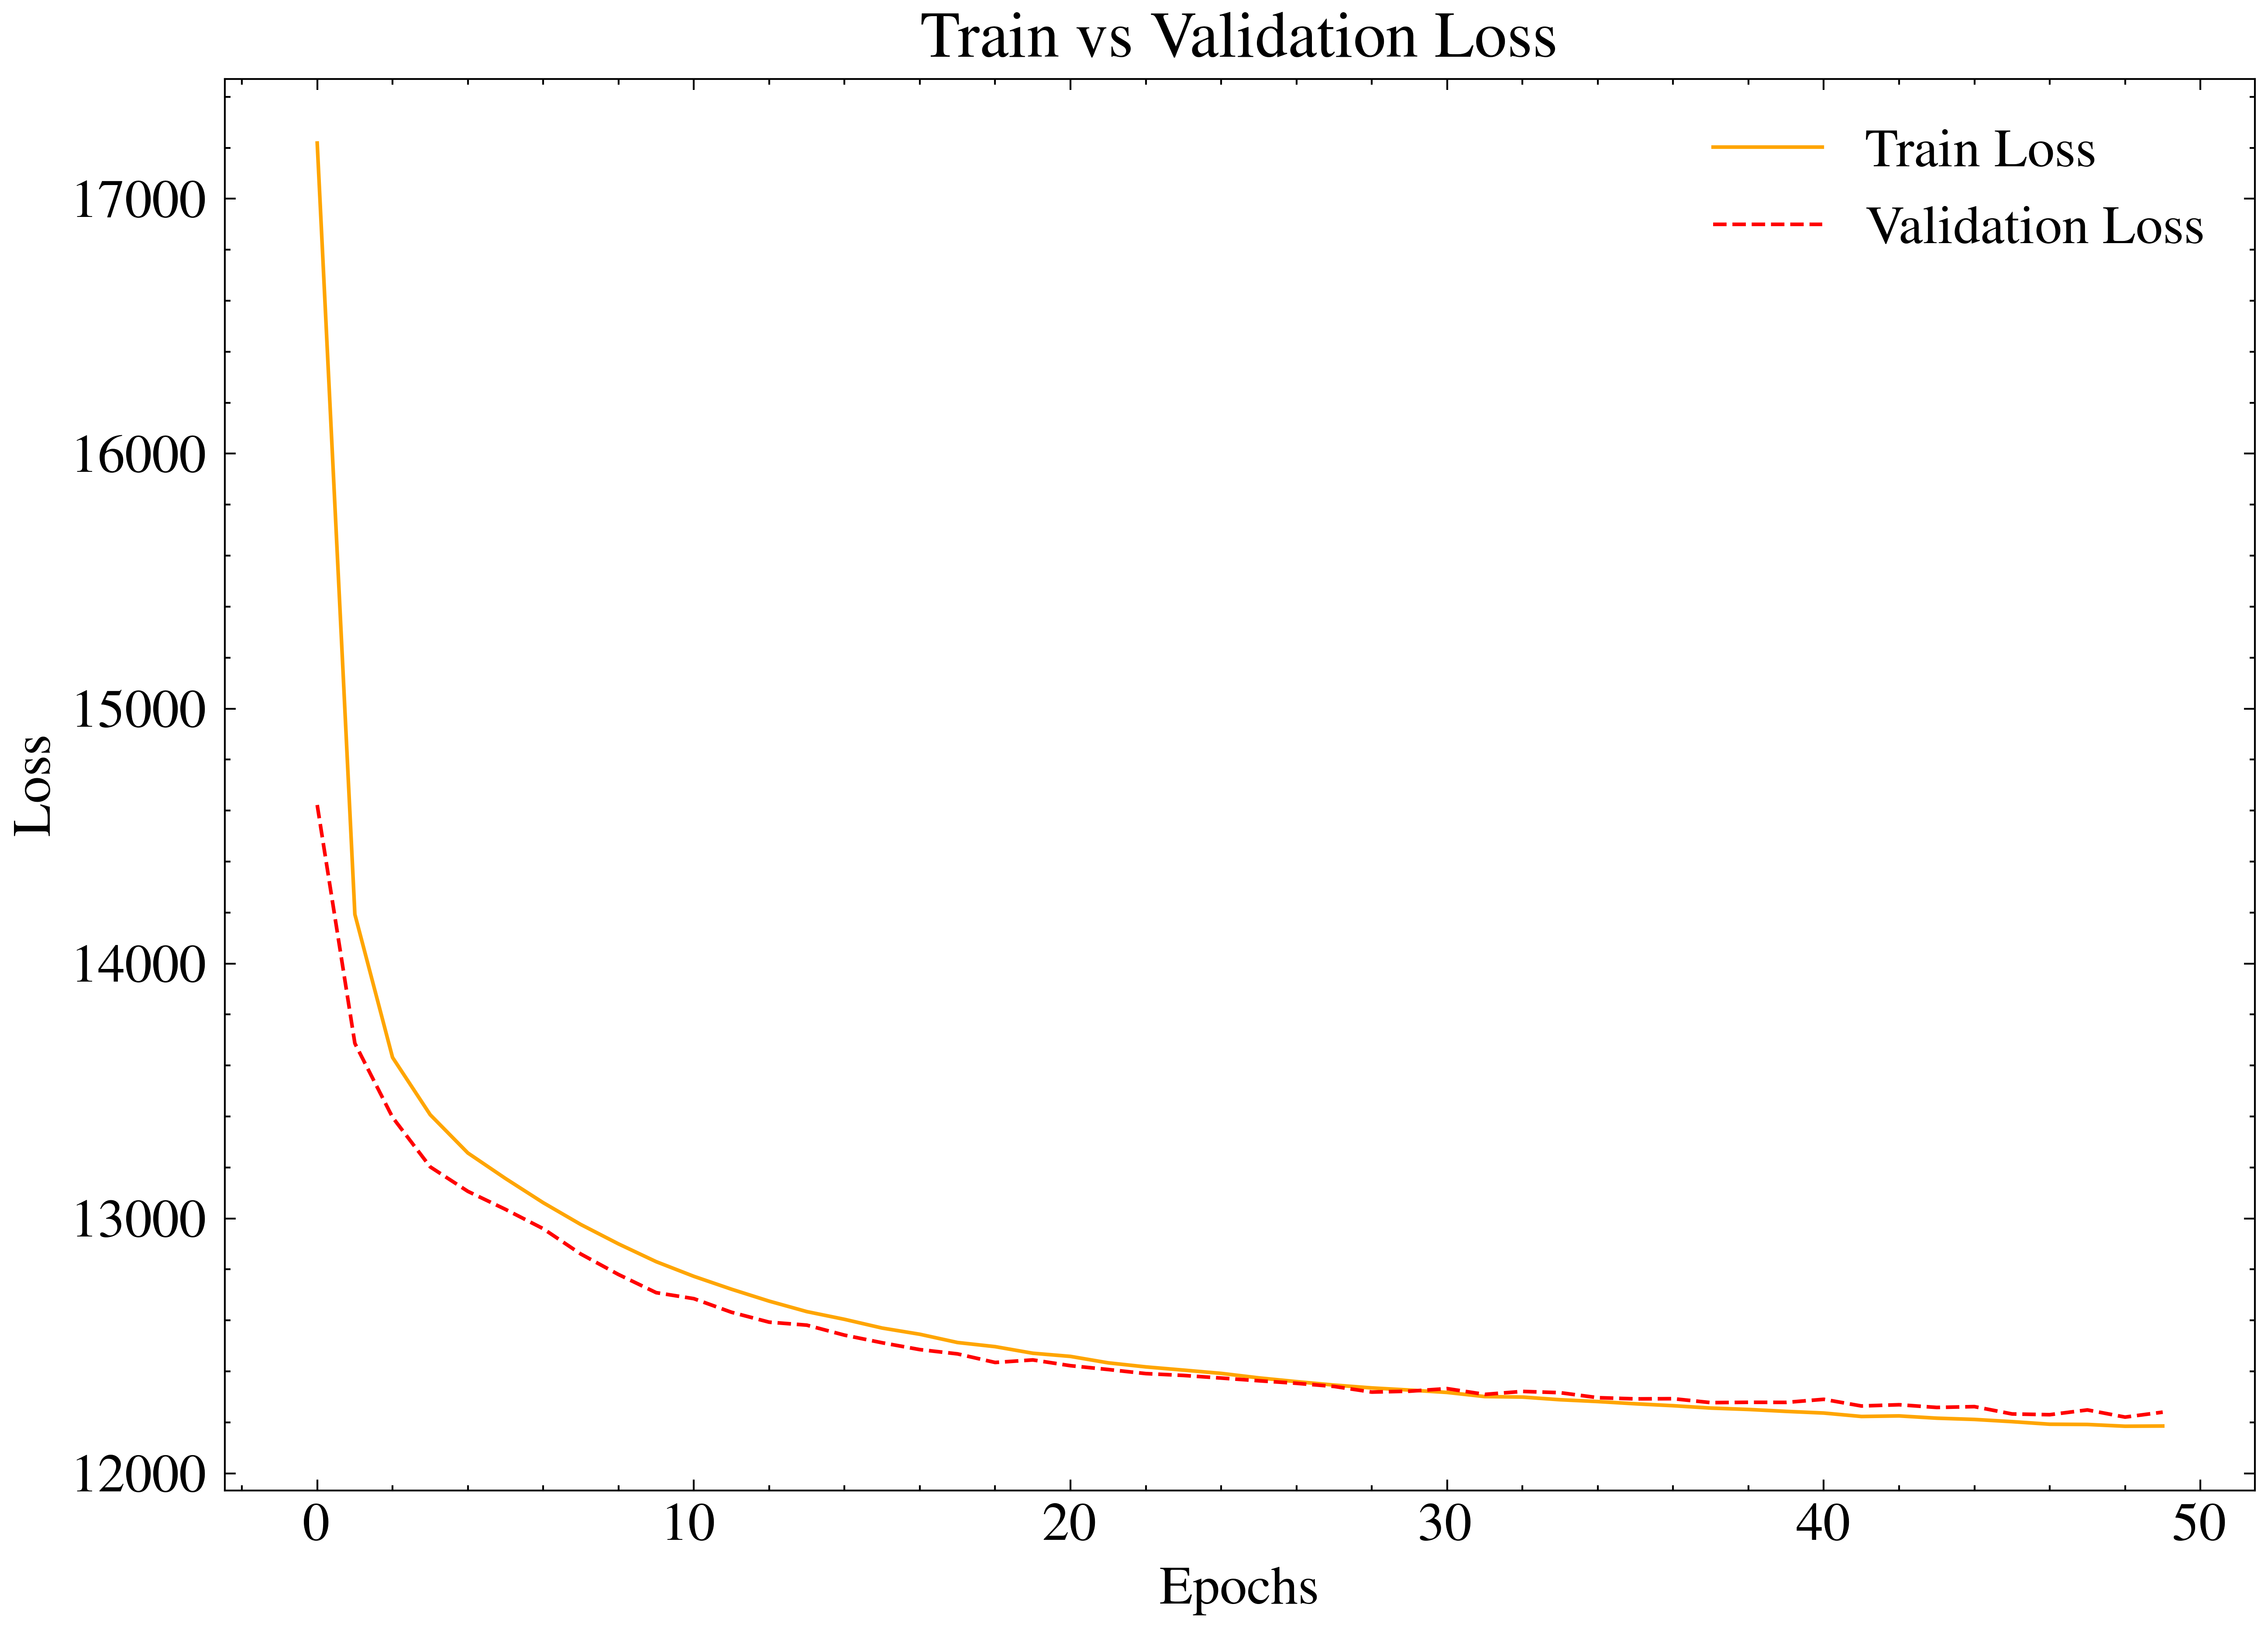

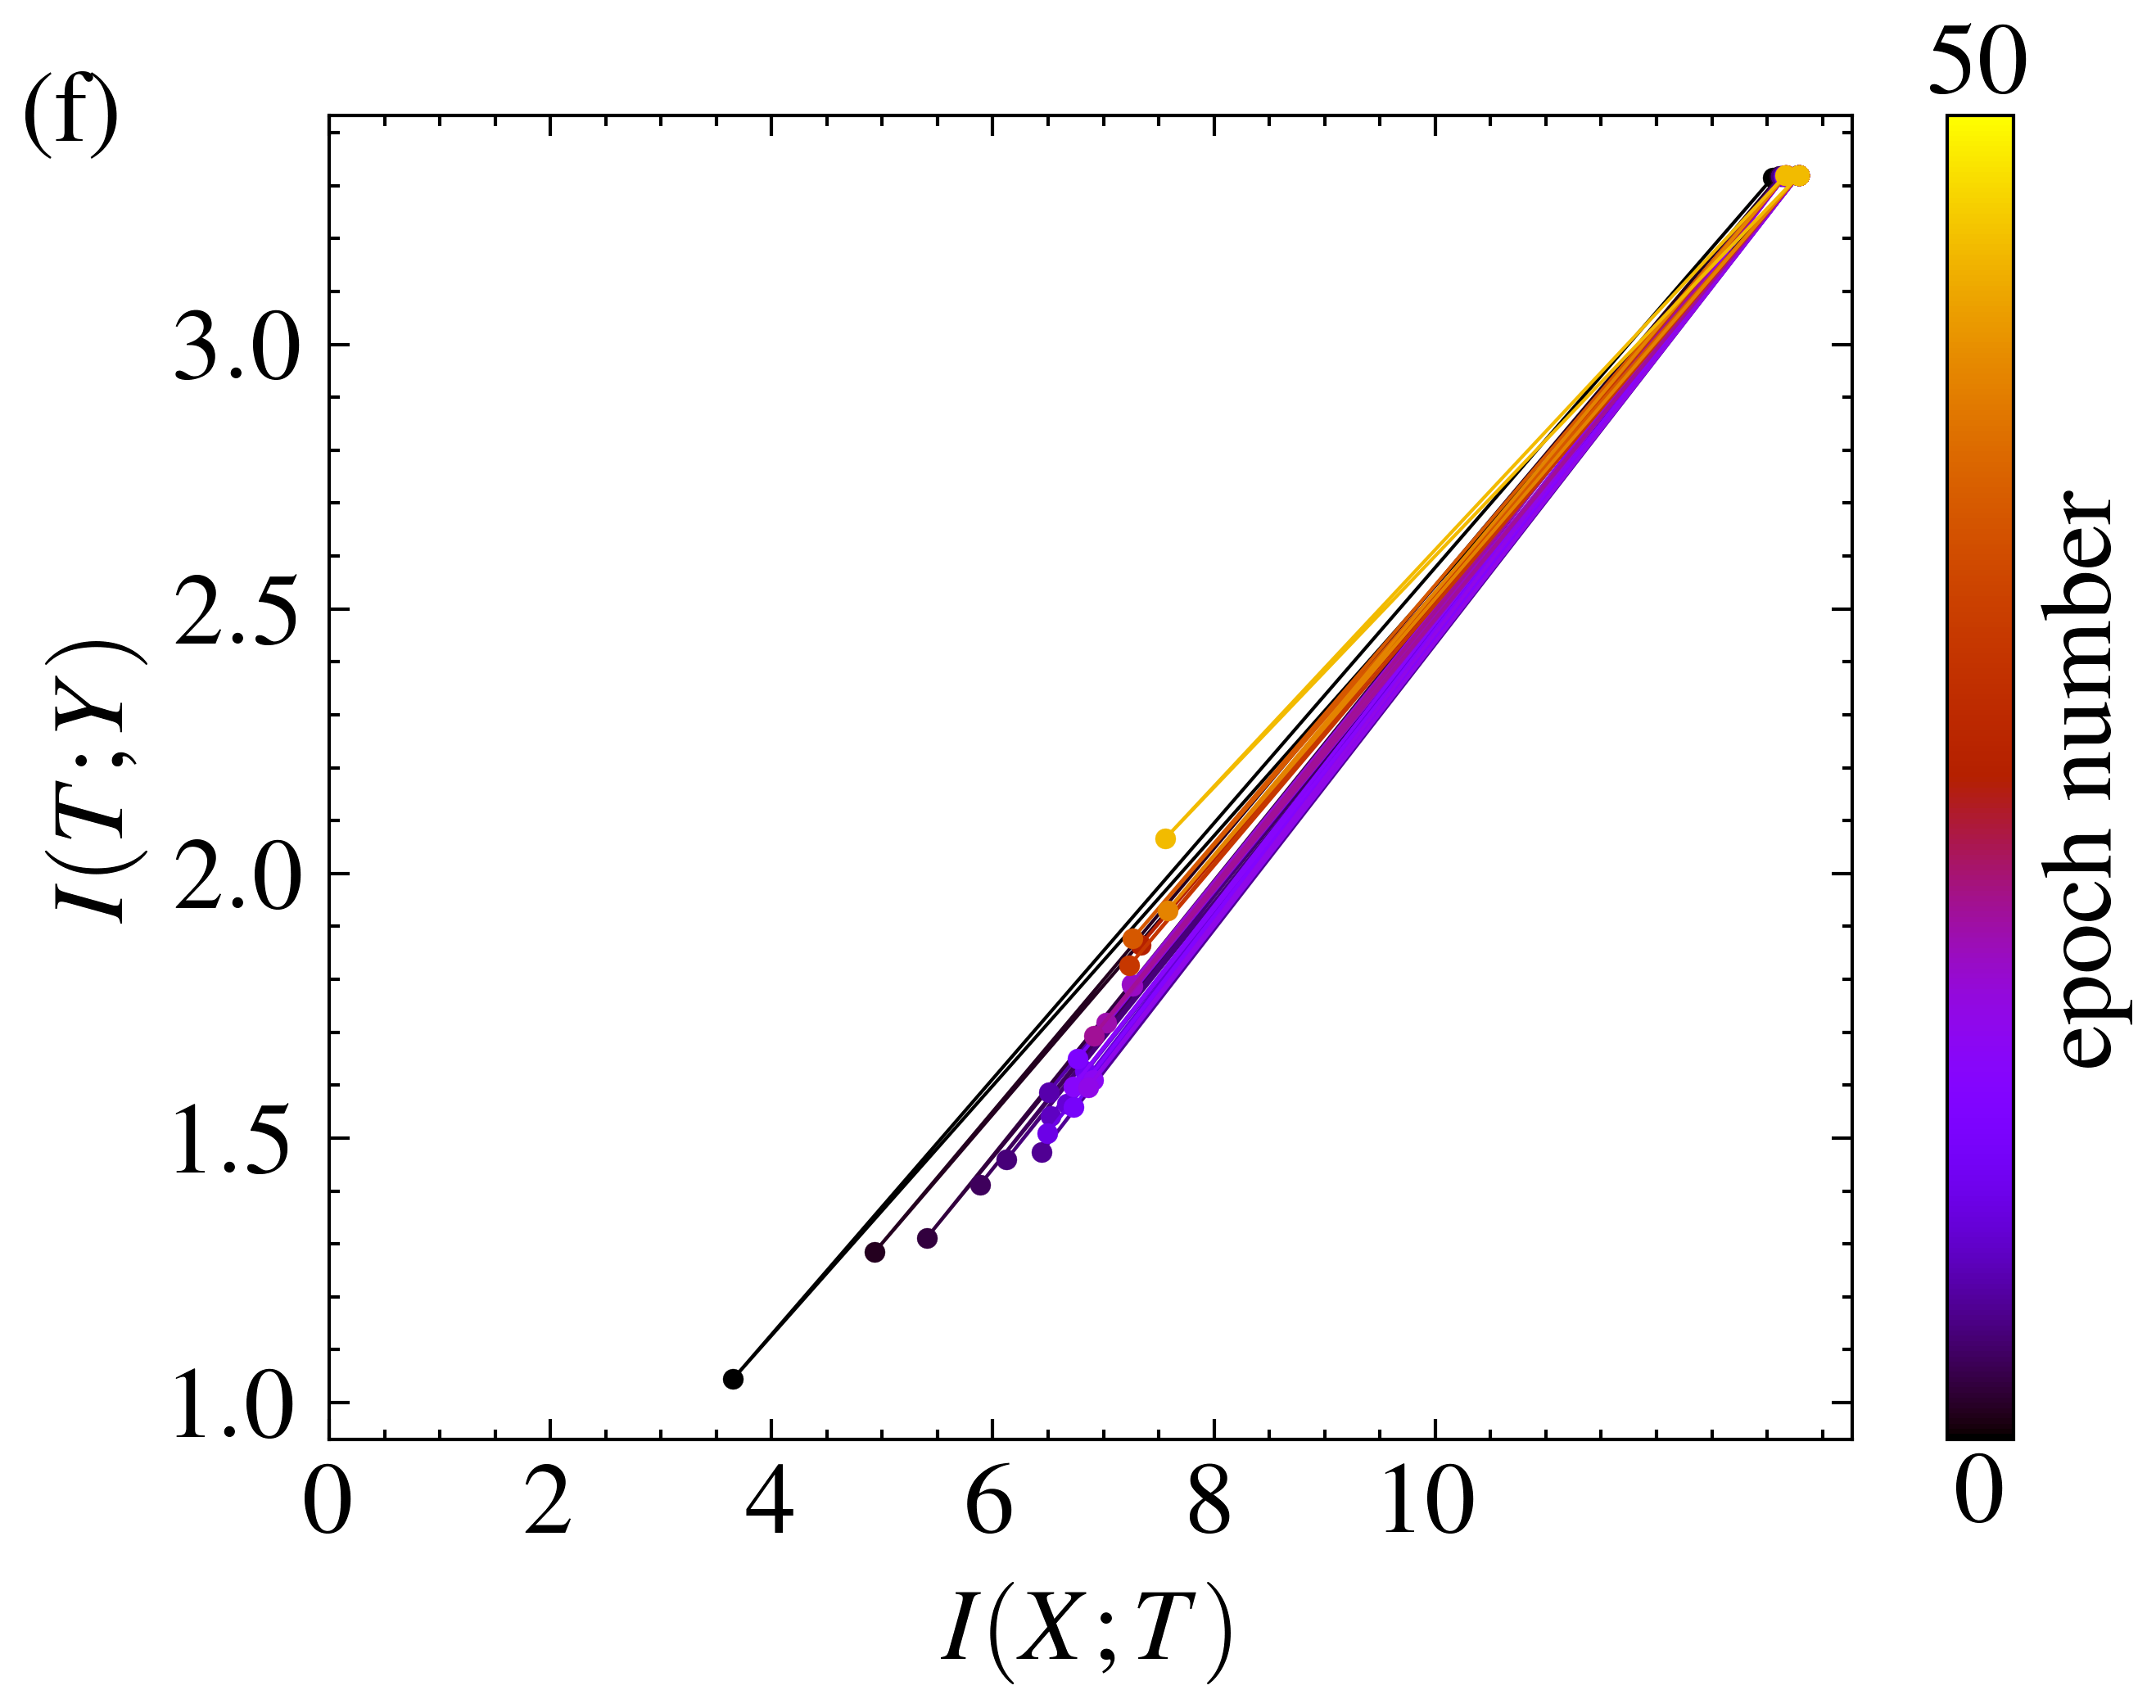

In [7]:
import torchvision
import kde
import simplebinmi
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
import scienceplots
import math
# train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')

accuracy_S = []

class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(1.93))

    def forward(self, input):
        # temp = input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))#GELU
        temp = input*torch.sigmoid(input/self.sigma)#SiLU
        return temp


class VAE(nn.Module):
    def __init__(self, num_classes=10):
        super(VAE, self).__init__()

        # VAE部分
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2_mu = nn.Linear(512, 10)
        self.fc2_sig = nn.Linear(512, 10)
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 784)

        # 分类器部分
        self.fc_classifier = nn.Linear(10, num_classes)  # 假设z的维度为10
        # 激活函数
        self.custom_activation = CustomActivation()

    def encode(self, x, activations):
        x = x.to(next(self.fc1.parameters()).device)  # 将输入移动到模型所在设备
        a1 = self.custom_activation(self.fc1(x))
        activations.append(a1.detach().cpu().numpy())  # 保存编码器第一层激活值（转为 CPU）
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        activations.append(a_mu.detach().cpu().numpy())  # 保存均值激活值
        activations.append(a_logvar.detach().cpu().numpy())  # 保存方差激活值
        return a_mu, a_logvar

    def decode(self, z, activations):
        a3 = self.custom_activation(self.fc3(z))
        activations.append(a3.detach().cpu().numpy())  # 保存解码器第一层激活值
        a4 = torch.sigmoid(self.fc4(a3))
        activations.append(a4.detach().cpu().numpy())  # 保存解码器输出激活值
        return a4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        activations = []  # 初始化激活值存储列表
        mu, logvar = self.encode(x.view(-1, 784), activations)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, activations)

        # 分类任务
        class_output = self.fc_classifier(z)  # 使用潜在向量z进行分类

        return recon_x, mu, logvar, class_output, activations


# 数据加载
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

full_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)


# 模型初始化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)  # 将模型加载到指定设备
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# 损失函数
# 定义 BETA 超参数
BETA = 1.5

def loss_function(recon_x, x, mu, logvar, class_output=None, labels=None):
    # 重建损失（Binary Cross-Entropy）
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # 信息瓶颈损失（KL 散度）
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / math.log(2)

    # 分类损失（Cross-Entropy）
    CE = 0
    if class_output is not None and labels is not None:
        CE = F.cross_entropy(class_output, labels)

    # 总损失
    total_loss = CE + BCE + BETA * KL
    return total_loss


# 训练阶段
num_epochs = 50
print_per = 100
# 初始化损失记录列表
train_losses = []
valid_losses = []
class MI_Plate():
    def __init__(self, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()

        self.n_epochs = num_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    # DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):

        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')

        # if train_on_gpu:
        #     model.cuda()

        for epoch in range(self.n_epochs):
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                # if train_on_gpu:
                #     data, target = data.cuda(), target.cuda()  # Move data to GPU
                images = images.reshape(-1, 28 * 28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_output, activations = model(images)
                loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)  # 平均训练损失
            train_losses.append(train_loss)


            model.eval()
            for data, _ in full_data_loader:
                # if train_on_gpu:
                #     data = data.cuda()  # Move data to GPU
                recon_x, mu, logvar, class_output, activations = model(data)
            # 定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:  # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            # pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):  # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):  # Then every 10th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):  # Then every 100th
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)


            valid_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.reshape(-1, 28 * 28).to(device)
                    labels = labels.to(device)

                    # 通过VAE模型进行前向传播
                    recon_batch, mu, logvar, class_output, activations = model(images)
                    # 使用mu通过分类器进行预测
                    class_output = model.fc_classifier(mu)  # 假设有分类头fc_classifier
                    predicted_labels = torch.argmax(class_output, dim=1)  # 选择最大概率的标签

                    # 计算分类准确率
                    total += labels.size(0)
                    correct += (predicted_labels == labels).sum().item()
                    # 计算重建损失
                    loss = loss_function(recon_batch, images, mu, logvar, class_output, labels)
                    valid_loss += loss.item()

            # 平均验证损失
            valid_loss /= len(test_loader)
            # 计算分类准确率
            accuracy = 100 * correct / total

            valid_losses.append(valid_loss)  # 记录验证损失
            accuracy_S.append(accuracy) 
           
            np.save('D:/深度学习与信息论/accuracy_S.npy', np.array(accuracy_S)) 
            print(f"Epoch [{epoch}/{self.n_epochs}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def compute_MI(self, noise_variance=1e-1):

        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance

        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)

        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0 / np.log(2)

        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_dataset.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
        ###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['SiLU'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['SiLU']:  # Skip this epoch if its already been processed
                continue  # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []

            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    # h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper = 0.0
                for i in range(10):
                    # 修正 saved_labelixs 为适配 activity 的布尔索引
                    batch_indices = torch.arange(activity.shape[0])  # 当前批次索引范围
                    saved_labelixs_batch = saved_labelixs[i][batch_indices]  # 修正为匹配当前批次的索引

                    # 计算条件熵
                    hcond_upper = entropy_func_upper(activity[saved_labelixs_batch, :])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower = 0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i], :])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append(nats2bits * (h_upper - hM_given_X))
                cepochdata['MI_YM_upper'].append(nats2bits * (h_upper - hM_given_Y_upper))
                cepochdata['H_M_upper'].append(nats2bits * h_upper)

                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)

                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (
                cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append(nats2bits * (h_lower - hM_given_X))
                    cepochdata['MI_YM_lower'].append(nats2bits * (h_lower - hM_given_Y_lower))
                    cepochdata['H_M_lower'].append(nats2bits * h_lower)
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED:  # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append(nats2bits * binxm)
                    cepochdata['MI_YM_bin'].append(nats2bits * binym)
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (
                    cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr))

            measures['SiLU'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)


            # epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array,dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array,dtype=object)

        # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_vibS.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_vibS.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)


Plate = MI_Plate()  # Create class object
Plate.save_activations()  # save activations if they weren't saved already
Plate.compute_MI()  # compute and save MIs if they weren't saved before


def save_loss_plot(train_loss, valid_loss):
    # 绘制损失曲线
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='Train Loss')
    plt.plot(valid_loss, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    
    plt.savefig('loss_vibS.eps')  # 保存为图片文件
    plt.show()

# 调用函数绘制损失图
save_loss_plot(train_losses, valid_losses)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})


def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i]
        ITY = ITY_array[i]

        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10])
    # ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.9, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(f)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/vibS.eps', dpi=800)
    plt.show()


IXT_array = np.load('D:/深度学习与信息论/MI_XM_vibS.npy', allow_pickle=True)

ITY_array = np.load('D:/深度学习与信息论/MI_YM_vibS.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5)

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # 加载保存的npy文件
# mi_xm_R= np.load('D:/深度学习与信息论/MI_XM_vibR.npy', allow_pickle=True)
# mi_ym_R = np.load('D:/深度学习与信息论/MI_YM_vibR.npy', allow_pickle=True)
# 
# mi_xm_G = np.load('D:/深度学习与信息论/MI_XM_vibG.npy', allow_pickle=True)
# mi_ym_G = np.load('D:/深度学习与信息论/MI_YM_vibG.npy', allow_pickle=True)
# 
# mi_xm_S = np.load('D:/深度学习与信息论/MI_XM_vibS.npy', allow_pickle=True)
# mi_ym_S= np.load('D:/深度学习与信息论/MI_YM_vibS.npy', allow_pickle=True)
# 
# 
# # 提取第3层的数据 (索引从0开始，第3层是索引2)
# mi_xm_R_data = mi_xm_R[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_R_data = mi_ym_R[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# mi_xm_G_data = mi_xm_G[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_G_data = mi_ym_G[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# mi_xm_S_data = mi_xm_S[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_S_data = mi_ym_S[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# # 绘制图形
# epochs = np.arange(mi_xm_R_data.shape[0])  # 生成一个长度为 27 的 epoch 数组
# 
# plt.figure(figsize=(10, 6))
# 
# plt.plot(epochs, mi_xm_R_data, label='IXT_ReLU)', color='b', linestyle='-', marker='o')
# plt.plot(epochs, mi_ym_R_data, label='IYT_ReLU', color='r', linestyle='-', marker='x')
# 
# plt.plot(epochs, mi_xm_G_data, label='IXT_GELU', color='g', linestyle='-', marker='s')
# plt.plot(epochs, mi_ym_G_data, label='IYT_GELU', color='y', linestyle='-', marker='d')
# 
# plt.plot(epochs, mi_xm_S_data,label='IXT_SiLU', color='c', linestyle='-', marker='^')
# plt.plot(epochs, mi_ym_S_data, label='IYT_SiLU', color='m', linestyle='-', marker='p')
# 
# # 添加标题和标签
# plt.title('Mutual Information at Layer 4 for Different Epochs', fontsize=14)
# plt.xlabel('Epochs', fontsize=12)
# plt.ylabel('Mutual Information', fontsize=12)
# plt.legend()
# 
# # 显示图形
# plt.grid(True)
# plt.show()

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # 加载保存的npy文件
# mi_xm_layer0 = np.load('MI_XM_vibG_layer0.npy', allow_pickle=True)
# mi_ym_layer0 = np.load('MI_YM_vibG_layer0.npy', allow_pickle=True)
# 
# mi_xm_layer1 = np.load('MI_XM_vibG_layer1.npy', allow_pickle=True)
# mi_ym_layer1 = np.load('MI_YM_vibG_layer1.npy', allow_pickle=True)
# 
# # 检查数据的形状
# print("mi_xm_layer0 shape:", mi_xm_layer0.shape)
# print("mi_ym_layer0 shape:", mi_ym_layer0.shape)
# 
# print("mi_xm_layer1 shape:", mi_xm_layer1.shape)
# print("mi_ym_layer1 shape:", mi_ym_layer1.shape)
# 
# # 提取第3层的数据 (索引从0开始，第3层是索引2)
# mi_xm_layer0_data = mi_xm_layer0[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_layer0_data = mi_ym_layer0[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# mi_xm_layer1_data = mi_xm_layer1[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_layer1_data = mi_ym_layer1[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# # 绘制信息平面函数
# def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
#     assert len(IXT_array) == len(ITY_array)
# 
#     max_index = len(IXT_array)
# 
#     fig, ax = plt.subplots(figsize=(5, 3.5))
#     ax.set_xlabel('$I(X;T)$', fontsize=15)
#     ax.set_ylabel('$I(T;Y)$', fontsize=15)
# 
#     cmap = plt.get_cmap('gnuplot')
#     colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]
# 
#     for i in range(0, max_index):
#         IXT = IXT_array[i]
#         ITY = ITY_array[i]
# 
#         # 根据 epoch 的范围调整 every_n
#         if i < 20:
#             color_idx = i * every_n_early
#         else:
#             color_idx = 20 * every_n_early + (i - 20) * every_n_late
# 
#         ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
#                 linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)
# 
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
#     sm._A = []
# 
#     # 使用ax参数指定颜色条位置
#     cbar = plt.colorbar(sm, ax=ax, ticks=[])
#     cbar.set_label('Epoch number', fontsize=15)
#     cbar.ax.tick_params(labelsize=15)
#     cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
#     cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')
# 
#     ax.set_xticks([0, 2, 4, 6, 8, 10])
#     ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
# 
#     # Adjust coordinates of text according to the plot area
#     ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)
# 
#     # 显示图形
#     plt.show()
# 
# # 生成epoch数组
# epochs = np.arange(mi_xm_layer0_data.shape[0])
# 
# # 调用绘制函数
# plot_information_plane(mi_xm_layer0_data, mi_ym_layer0_data, num_epochs=27)
# plot_information_plane(mi_xm_layer1_data, mi_ym_layer1_data, num_epochs=27)


In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # 加载保存的npy文件
# mi_xm_R = np.load('D:/深度学习与信息论/MI_XM_vibR.npy', allow_pickle=True)
# mi_ym_R = np.load('D:/深度学习与信息论/MI_YM_vibR.npy', allow_pickle=True)
# 
# mi_xm_G = np.load('D:/深度学习与信息论/MI_XM_vibG.npy', allow_pickle=True)
# mi_ym_G = np.load('D:/深度学习与信息论/MI_YM_vibG.npy', allow_pickle=True)
# 
# mi_xm_S = np.load('D:/深度学习与信息论/MI_XM_vibS.npy', allow_pickle=True)
# mi_ym_S = np.load('D:/深度学习与信息论/MI_YM_vibS.npy', allow_pickle=True)
# 
# # 提取第3层的数据 (索引从0开始，第3层是索引2)
# mi_xm_R_data = mi_xm_R[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_R_data = mi_ym_R[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# mi_xm_G_data = mi_xm_G[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_G_data = mi_ym_G[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# mi_xm_S_data = mi_xm_S[:, 2]  # 提取所有epoch的第3层MI(X;M)
# mi_ym_S_data = mi_ym_S[:, 2]  # 提取所有epoch的第3层MI(Y;M)
# 
# # 生成一个长度为 27 的 epoch 数组
# epochs = np.arange(mi_xm_R_data.shape[0])
# 
# # 绘制MI(X;T)的图形
# plt.figure(figsize=(10,6))
# plt.plot(epochs, mi_xm_R_data, label='MI(X;M) at ReLU', color='b', linestyle='-', marker='o')
# plt.plot(epochs, mi_xm_G_data, label='MI(X;M) at GELU', color='g', linestyle='-', marker='s')
# plt.plot(epochs, mi_xm_S_data, label='MI(X;M) at SiLU', color='c', linestyle='-', marker='^')
# 
# plt.title('MI(X;T) at Layer 3 for Different Activations', fontsize=14)
# plt.xlabel('Epochs', fontsize=12)
# plt.ylabel('Mutual Information', fontsize=12)
# plt.legend()
# # plt.savefig('D:/深度学习与信息论/IXT.eps', dpi=800, bbox_inches='tight')
# plt.grid(True)
# plt.show()
# 
# # 绘制MI(Y;T)的图形
# plt.figure(figsize=(10,6))
# plt.plot(epochs, mi_ym_R_data, label='MI(Y;M) at ReLU', color='r', linestyle='-', marker='x')
# plt.plot(epochs, mi_ym_G_data, label='MI(Y;M) at GELU', color='y', linestyle='-', marker='d')
# plt.plot(epochs, mi_ym_S_data, label='MI(Y;M) at SiLU', color='m', linestyle='-', marker='p')
# 
# plt.title('MI(Y;T) at Layer 3 for Different Activations', fontsize=14)
# plt.xlabel('Epochs', fontsize=12)
# plt.ylabel('Mutual Information', fontsize=12)
# plt.legend()
# # plt.savefig('D:/深度学习与信息论/IYT.eps', dpi=800,bbox_inches='tight')
# plt.grid(True)
# plt.show()


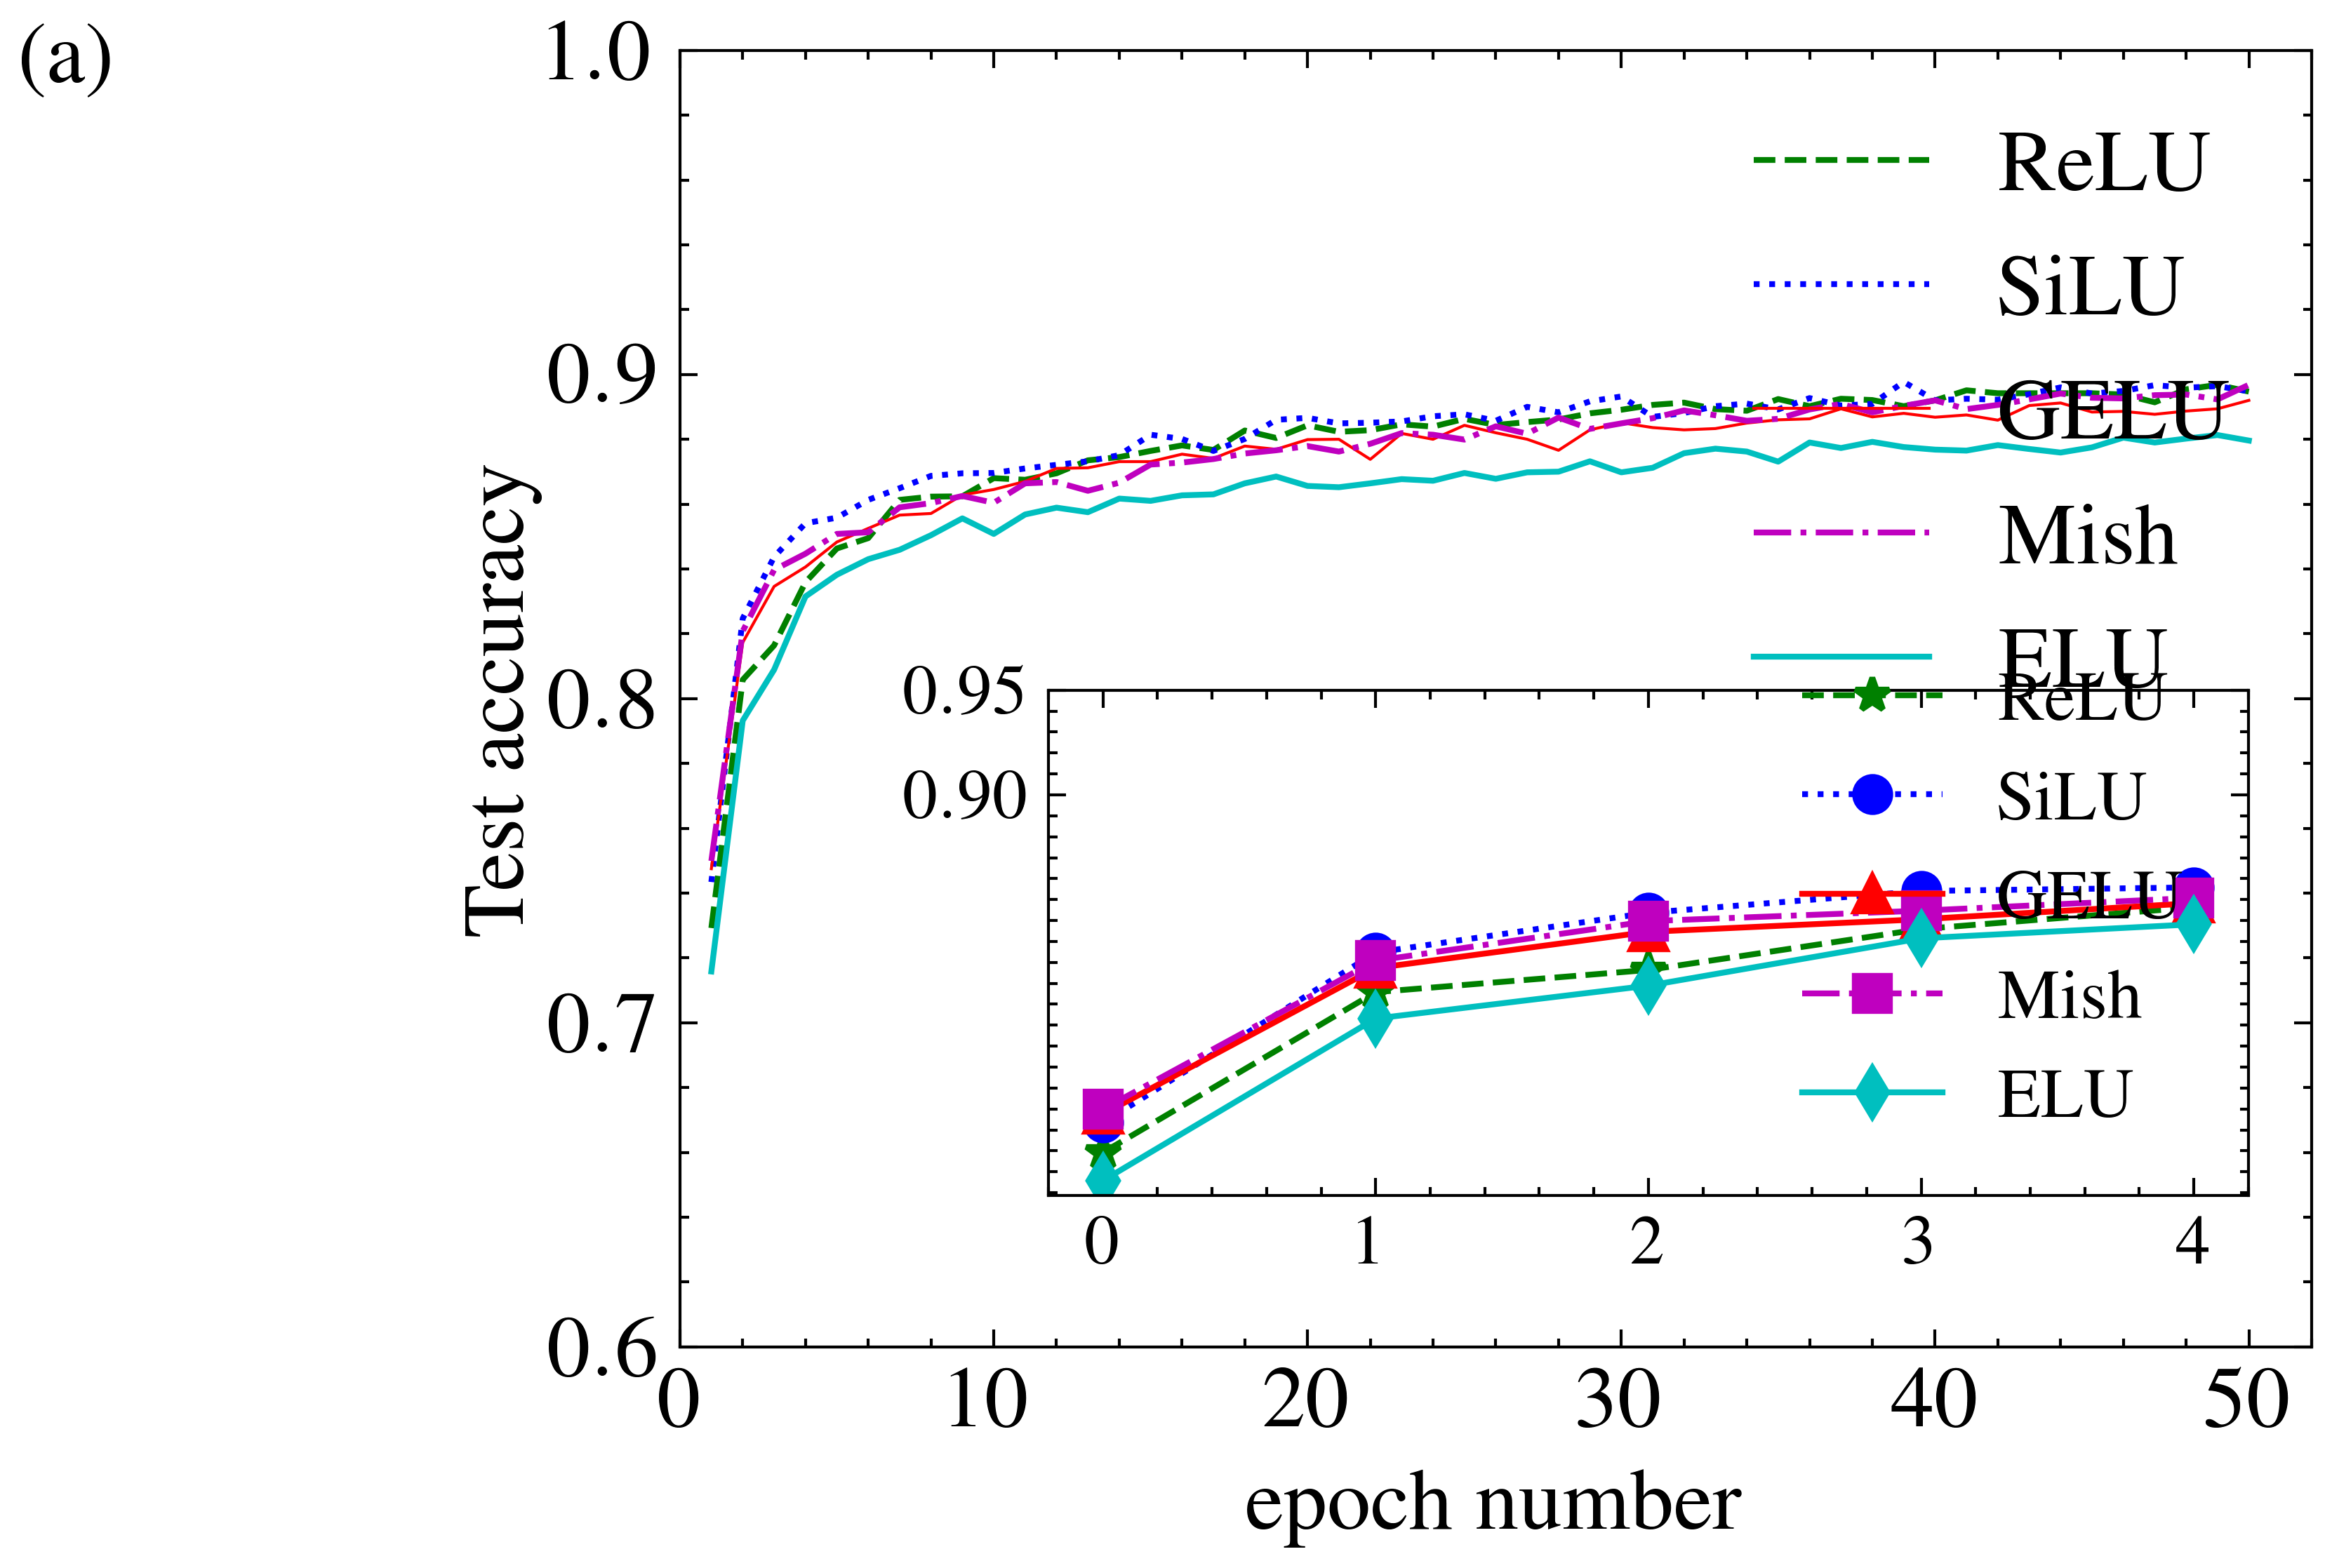

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
accuracyR = np.load('D:/深度学习与信息论/accuracy_R.npy',allow_pickle=True)
accuracyG = np.load('D:/深度学习与信息论/accuracy_G.npy',allow_pickle=True)
accuracyS = np.load('D:/深度学习与信息论/accuracy_S.npy',allow_pickle=True)
accuracyM = np.load('D:/深度学习与信息论/accuracy_M.npy',allow_pickle=True)
accuracyE = np.load('D:/深度学习与信息论/accuracy_E.npy',allow_pickle=True)
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
plt.style.use(['science','ieee'])

fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel(r"Test accuracy", fontsize=15, labelpad=1)
ax.set_xlim(0, len(accuracyR)+2)  # Adjust x-axis limits to start from epoch 1
ax.set_ylim(0.6, 1)

# Create the x-axis array to represent epoch numbers
epochs = np.arange(1, len(accuracyR)+1)

# Plot the accuracy curves
ax.plot(epochs, 0.01*accuracyR, 'g--', lw=1, label=r"ReLU")
ax.plot(epochs, 0.01*accuracyS, 'b:', lw=1, label=r"SiLU")
ax.plot(epochs, 0.01*accuracyG, 'r-', lw=0.5, label=r"GELU")
ax.plot(epochs, 0.01 * accuracyM, 'm-.', lw=1, label=r"Mish")   # 洋红色点划线
ax.plot(epochs, 0.01 * accuracyE, 'c-', lw=1, label=r"ELU") 
ax.text(-21, 0.99, '(a)', fontdict={'size': 15, 'color': 'black'})
ax.legend(loc='upper right', fontsize=15)

#patch = mpl.patches.Rectangle((0.1,0),0.8,5,linewidth=1,linestyle='--',edgecolor='gray',facecolor='none')
#ax.add_patch(patch)
left, bottom, width, height = [0.3, 0.2, 0.57, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

step = np.arange(0,101)
ax2.plot(step[0:5], 0.01*accuracyR[0:5], 'g--', marker='*',label=r"ReLU")
ax2.plot(step[0:5], 0.01*accuracyS[0:5], 'b:', marker='o',label=r"SiLU")
ax2.plot(step[0:5], 0.01*accuracyG[0:5], 'r-', marker='^',label=r"GELU")
ax2.plot(step[0:5], 0.01 * accuracyM[0:5], 'm-.', marker='s', label=r"Mish")
ax2.plot(step[0:5], 0.01 * accuracyE[0:5], 'c-', marker='d', label=r"ELU")
ax2.set_yticks([0.90,0.95])

ax2.tick_params(labelsize=12)
ax2.legend(loc='lower right', fontsize=12)
plt.show()

fig.savefig('D:/深度学习与信息论/FigvibME.eps', dpi=800)